<a href="https://colab.research.google.com/github/shriman/storelift_sales_prediction/blob/main/storelift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# test runtime config
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


# Imports

In [4]:
import os
import os
import seaborn as sns
from os import path
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 50

data_path = '/content/drive/My Drive/Colab Notebooks/storelift/data'
output_path = '/content/drive/My Drive/Colab Notebooks/storelift/outputs'

# Some helper functions and filenames


In [5]:
def get_source_filename(data_path, filename, suffix=None):
    if suffix:
        return os.path.join(data_path, filename + '.' + suffix)
    
    return os.path.join(data_path, filename + '.csv' )


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df


inventory_snapshots_fname = get_source_filename(data_path, 'inventory_snapshots')
invoiceable_lines_fname = get_source_filename(data_path, 'invoiceable_lines')
invoiceables_fname = get_source_filename(data_path, 'invoiceables')
products_fname = get_source_filename(data_path, 'products')

print(inventory_snapshots_fname)

print(output_path)


/content/drive/My Drive/Colab Notebooks/storelift/data/inventory_snapshots.csv
/content/drive/My Drive/Colab Notebooks/storelift/outputs


# Read the data

In [6]:
inventory_snapshots = pd.read_csv(inventory_snapshots_fname, ',', low_memory=False)
print(inventory_snapshots.shape)
inventory_snapshots.head()

(110828, 5)


,store_id,product_id,product_count,snapshot_date,capacity
0,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,3,2020-09-28 17:04:36,NaN
1,5f1198de8746ae00042869ba,5f10761c34250d00047bd2c0,4,2020-09-28 17:04:36,NaN
2,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8b3,7,2020-09-28 17:04:36,NaN
3,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8b6,3,2020-09-28 17:04:36,NaN
4,5f1198de8746ae00042869ba,5ecf7ebfe624c40004a394e3,3,2020-09-28 17:04:36,NaN


In [7]:
inventory_snapshots.store_id.unique()

array(['5f1198de8746ae00042869ba', '5f60c3bbf4ff730004b46600',
       '5f898d328fd8fa000492a14d', '5fca2dbdabdffb0004e1d05a',
       '5fe3228d8babb6001700452b'], dtype=object)

In [8]:
inventory_snapshots = inventory_snapshots.rename(columns={"capacity": "capacity_inventory_snapshot"})
inventory_snapshots.head()

,store_id,product_id,product_count,snapshot_date,capacity_inventory_snapshot
0,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,3,2020-09-28 17:04:36,NaN
1,5f1198de8746ae00042869ba,5f10761c34250d00047bd2c0,4,2020-09-28 17:04:36,NaN
2,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8b3,7,2020-09-28 17:04:36,NaN
3,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8b6,3,2020-09-28 17:04:36,NaN
4,5f1198de8746ae00042869ba,5ecf7ebfe624c40004a394e3,3,2020-09-28 17:04:36,NaN


In [10]:
products = pd.read_csv(products_fname, ',', low_memory=False)
print(products.shape)
products.head()

(1168, 15)


,product_id,name,brand,weight,barcode,capacity,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration
0,5d0794866885630014681b97,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False
1,5cebfa8d0b259700045dc8b2,Biscuit lait chocolat,GERBLÉ,270,3175680011534,230,g,"[{""text"": ""Farine de BLE 50,1%, sucre de canne...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},GERBLÉ Biscuit lait chocolat,True
2,5d0794866885630014681b9c,"Home - Serviettes 2 épaisseurs 32,5x32,5 cm rouge",DOMÉDIA,167,3250391451548,1,item,"[{""text"": ""Domédia à votre écoute au 0 800 008...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"DOMÉDIA Home - Serviettes 2 épaisseurs 32,5x32...",False
3,602a2d81304b800015a177ca,Oeuf Kinder Surprise x3,KINDER,105,8000500348956,60,g,[],"{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,chocolats_bonbons,{titres_restaurants},KINDER Oeuf Kinder Surprise x3,True
4,602a2c983ddc3100158d6b06,Soupe légumes et vermicelles,LIEBIG,1065,3036811367787,1000,ml,[],"{""fr"": ""fr/food""}",epicerie_salee,https://storebox-api-public-production.s3.amaz...,soupes_croutons,{titres_restaurants},LIEBIG Soupe légumes et vermicelles,True


In [11]:
products = products.rename(columns={"capacity": "capacity_product"})
products.head()

,product_id,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration
0,5d0794866885630014681b97,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False
1,5cebfa8d0b259700045dc8b2,Biscuit lait chocolat,GERBLÉ,270,3175680011534,230,g,"[{""text"": ""Farine de BLE 50,1%, sucre de canne...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},GERBLÉ Biscuit lait chocolat,True
2,5d0794866885630014681b9c,"Home - Serviettes 2 épaisseurs 32,5x32,5 cm rouge",DOMÉDIA,167,3250391451548,1,item,"[{""text"": ""Domédia à votre écoute au 0 800 008...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"DOMÉDIA Home - Serviettes 2 épaisseurs 32,5x32...",False
3,602a2d81304b800015a177ca,Oeuf Kinder Surprise x3,KINDER,105,8000500348956,60,g,[],"{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,chocolats_bonbons,{titres_restaurants},KINDER Oeuf Kinder Surprise x3,True
4,602a2c983ddc3100158d6b06,Soupe légumes et vermicelles,LIEBIG,1065,3036811367787,1000,ml,[],"{""fr"": ""fr/food""}",epicerie_salee,https://storebox-api-public-production.s3.amaz...,soupes_croutons,{titres_restaurants},LIEBIG Soupe légumes et vermicelles,True


In [12]:
invoiceables = pd.read_csv(invoiceables_fname, ',', low_memory=False)
print(invoiceables.shape)
invoiceables.head()

(8851, 7)


,invoiceable_id,created_at,customer_id,store_id,total_after_vat,total_before_vat,total_to_pay
0,5f231001f3b5270004058133,2020-07-30 20:22:57,5de65f4b0d8add0004572f7e,5f1198de8746ae00042869ba,0,0,0
1,5f2314edf3b5270004058137,2020-07-30 20:43:57,5d7b63de25484a000498e53c,5f1198de8746ae00042869ba,270,256,270
2,5f294471bb1505000469d477,2020-08-04 13:20:17,5d768c85d15280000488a0ba,5f1198de8746ae00042869ba,500,474,500
3,5f294543bb1505000469d48d,2020-08-04 13:23:47,5de65f4b0d8add0004572f7e,5f1198de8746ae00042869ba,360,341,360
4,5f2912c0bb1505000469d3f6,2020-08-04 09:48:16,5d768c85d15280000488a0ba,5f1198de8746ae00042869ba,290,275,290


In [209]:
invoiceables.invoiceable_id.nunique()

8851

In [13]:
invoiceables.store_id.unique()

array(['5f1198de8746ae00042869ba', '5f60c3bbf4ff730004b46600',
       '5f898d328fd8fa000492a14d', '5fca2dbdabdffb0004e1d05a'],
      dtype=object)

In [14]:
invoiceable_lines = pd.read_csv(invoiceable_lines_fname, ',', low_memory=False)
print(invoiceable_lines.shape)
invoiceable_lines.head()

(33060, 10)


,invoiceable_id,line_detail_index,amount,product_id,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label
0,5f294471bb1505000469d477,0,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE
1,5f294471bb1505000469d477,1,250,5f119cbd8746ae0004286a26,False,False,True,False,fr/food,Product: LE KIOSQUE A SANDWICHES - CLUB ŒUF BI...
2,5f294471bb1505000469d477,2,140,5f1ebfc1f66f080004a7243c,False,False,True,False,fr/food,Product: Muffy Muffins - Muffin myrtilles
3,5f294543bb1505000469d48d,0,70,5ec4003f736e1800043e96f3,False,False,True,False,fr/food,CRISTALINE - BOISSON À L'EAU DE SOURCE ET JUS ...
4,5f294543bb1505000469d48d,1,290,5f119cbd8746ae0004286a27,False,False,True,False,fr/food,LE KIOSQUE A SANDWICHES - WRAP DUO POULET PAR...


In [15]:
invoiceable_lines.loc[invoiceable_lines.amount > 0].groupby(['amount', 'product_id']).count().reset_index().sort_values(['line_detail_index'])

,amount,product_id,invoiceable_id,line_detail_index,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label
0,1,5d2708015cf7710008f330b9,1,1,1,1,1,1,1,1
509,250,5efc36b4b840740004b1f24e,1,1,1,1,1,1,1,1
505,250,5ef221225178cb0004b0229d,1,1,1,1,1,1,1,1
87,100,5ff2ce582f740d0017a91639,1,1,1,1,1,1,1,1
479,230,5f90293bcb0db500041a8cfe,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
31,80,5ec4003f736e1800043e96f3,410,410,410,410,410,410,410,410
14,60,5d0794866885630014681bb7,413,413,413,413,413,413,413,413
646,399,5f7dc8d5e1bad90004b43b1a,437,437,437,437,437,437,437,437
379,190,5ef221225178cb0004b02291,469,469,469,469,469,469,469,469


In [16]:
invoiceable_lines.groupby(['invoiceable_id', 'product_id']).count().reset_index().sort_values(['line_detail_index'])

,invoiceable_id,product_id,line_detail_index,amount,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label
0,5f290aaabb1505000469d3da,5f119cbd8746ae0004286a30,1,1,1,1,1,1,1,1
15048,5fd79f9b341f5300040e9a55,5ef221225178cb0004b0229a,1,1,1,1,1,1,1,1
15047,5fd79f9b341f5300040e9a55,5d0794866885630014681bb7,1,1,1,1,1,1,1,1
15046,5fd79f9b341f5300040e9a55,5cebfa8d0b259700045dc8aa,1,1,1,1,1,1,1,1
15045,5fd79c35341f5300040e9a32,5f119cbd8746ae0004286a31,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
5416,5f848bef4874bd00045c8081,5d0794866885630014681b9a,14,14,14,14,14,14,14,14
4126,5f73afc5ad2ce90004c771b3,5ec3ef13bb5c33000401483c,14,14,14,14,14,14,14,14
4117,5f73afc5ad2ce90004c771b3,5d0794866885630014681b9a,14,14,14,14,14,14,14,14
11966,5fc0e0782fcf210004e469a8,5fb3907c2832680004fd0b6c,14,14,14,14,14,14,14,14


In [213]:
invoiceable_lines.is_promotion_campaign.value_counts()

False    27303
True      5757
Name: is_promotion_campaign, dtype: int64

In [17]:
# (invoiceable_lines.invoiceable_id == '5f848bef4874bd00045c8081') &
invoiceable_lines.loc[ (invoiceable_lines.product_id == '5ef221225178cb0004b02291')]

,invoiceable_id,line_detail_index,amount,product_id,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label
1517,5f46de3454835f0004b24a0a,6,190,5ef221225178cb0004b02291,False,False,True,False,fr/food,Product: SODEBO - SDW.LE MEGA CLUB VIENNOIS TH...
1609,5f478ad554835f0004b24b15,0,190,5ef221225178cb0004b02291,False,False,True,False,fr/food,SODEBO - SDW.LE MEGA CLUB VIENNOIS THON OEUF M...
1745,5f48f0655dc07400041acd9c,0,190,5ef221225178cb0004b02291,False,False,True,False,fr/food,SODEBO - SDW.LE MEGA CLUB VIENNOIS THON OEUF M...
1746,5f48f0655dc07400041acd9c,1,190,5ef221225178cb0004b02291,False,False,True,False,fr/food,SODEBO - SDW.LE MEGA CLUB VIENNOIS THON OEUF M...
1925,5f4c1c149ca8a8000497b9d0,2,190,5ef221225178cb0004b02291,False,False,True,False,fr/food,Product: SODEBO - SDW.LE MEGA CLUB VIENNOIS TH...
...,...,...,...,...,...,...,...,...,...,...
32831,60169c9dbb2d5e0004fe0c25,0,190,5ef221225178cb0004b02291,False,False,True,False,fr/food,SODEBO - Sandwich Le Méga - Club - Thon OEuf M...
32882,6016c098bb2d5e0004fe0ce4,1,190,5ef221225178cb0004b02291,False,False,True,False,fr/food,SODEBO - Sandwich Le Méga - Club - Thon OEuf M...
32922,6016cf21bb2d5e0004fe0d42,0,190,5ef221225178cb0004b02291,False,False,True,False,fr/food,SODEBO - Sandwich Le Méga - Club - Thon OEuf M...
32941,6016d088bb2d5e0004fe0d55,0,190,5ef221225178cb0004b02291,False,False,True,False,fr/food,SODEBO - Sandwich Le Méga - Club - Thon OEuf M...


In [18]:
invoiceables.isnull().sum()

invoiceable_id      0
created_at          0
customer_id         0
store_id            0
total_after_vat     0
total_before_vat    0
total_to_pay        0
dtype: int64

In [19]:
invoiceable_lines.isnull().sum()

invoiceable_id           0
line_detail_index        0
amount                   0
product_id               0
is_correction            0
is_discount              0
is_product               0
is_promotion_campaign    0
vat_id                   0
label                    0
dtype: int64

# Data exploration and cleaning and feature engineering



## Products

In [20]:
products.isnull().sum()

product_id           0
name                 0
brand                0
weight               0
barcode              0
capacity_product     0
capacity_unit        0
information          0
vat_id_by_country    0
category             0
product_image_url    1
sub_category         0
tags                 0
full_name            0
has_expiration       0
dtype: int64

In [21]:
# get different products 
products.groupby(['category', 'sub_category']).size().reset_index().sort_values([0], ascending=False).head(10)

,category,sub_category,0
16,epicerie_sucree,biscuits_gateaux,179
39,restauration,plats_cuisines_traiteur,103
42,restauration,sandwichs,102
8,epicerie_salee,chips_biscuits_aperitif,89
19,epicerie_sucree,chocolats_bonbons,71
1,boissons,boissons_sans_alcools,70
35,produits_frais,yaourts_compotes,68
23,hygiene_maison,hygiene_beaute,57
26,produits_frais,cremerie,40
30,produits_frais,pizza_quiches,34


In [22]:
product_ids_list = products.product_id.unique().tolist()
len(product_ids_list)

1168

In [23]:
# create new feature for product - 
# category_combined = category + sub_category 
# to get all unique product categories
products['category_combined'] = products['category'] + ' ' + products['sub_category']
products['has_expiration_int'] = products['has_expiration'].apply(lambda x: 1 if x else 0)
products.head()

,product_id,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int
0,5d0794866885630014681b97,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0
1,5cebfa8d0b259700045dc8b2,Biscuit lait chocolat,GERBLÉ,270,3175680011534,230,g,"[{""text"": ""Farine de BLE 50,1%, sucre de canne...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},GERBLÉ Biscuit lait chocolat,True,epicerie_sucree biscuits_gateaux,1
2,5d0794866885630014681b9c,"Home - Serviettes 2 épaisseurs 32,5x32,5 cm rouge",DOMÉDIA,167,3250391451548,1,item,"[{""text"": ""Domédia à votre écoute au 0 800 008...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"DOMÉDIA Home - Serviettes 2 épaisseurs 32,5x32...",False,hygiene_maison hygiene_beaute,0
3,602a2d81304b800015a177ca,Oeuf Kinder Surprise x3,KINDER,105,8000500348956,60,g,[],"{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,chocolats_bonbons,{titres_restaurants},KINDER Oeuf Kinder Surprise x3,True,epicerie_sucree chocolats_bonbons,1
4,602a2c983ddc3100158d6b06,Soupe légumes et vermicelles,LIEBIG,1065,3036811367787,1000,ml,[],"{""fr"": ""fr/food""}",epicerie_salee,https://storebox-api-public-production.s3.amaz...,soupes_croutons,{titres_restaurants},LIEBIG Soupe légumes et vermicelles,True,epicerie_salee soupes_croutons,1


In [204]:
products.sub_category.value_counts()

biscuits_gateaux           179
plats_cuisines_traiteur    105
sandwichs                  102
chips_biscuits_aperitif     89
yaourts_compotes            72
boissons_sans_alcools       71
chocolats_bonbons           71
hygiene_beaute              57
cremerie                    40
pizza_quiches               37
desserts                    30
salades_entrees             29
salades                     26
viandes_charcuteries        26
jus_de_fruits               25
entretien                   21
sauces_condiments           20
boissons_chaudes            19
soupes_croutons             19
pates_riz_feculents         18
apero_frais                 16
eaux                        15
conserves_bocaux            14
pains_patisseries           13
pates_fraiches              11
soupes_fraiches              9
fruits_legumes               8
vrac                         8
plats_cuisines               7
apero_tartinable             6
saces_condiments             4
yaourt_a_boire               1
Name: su

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


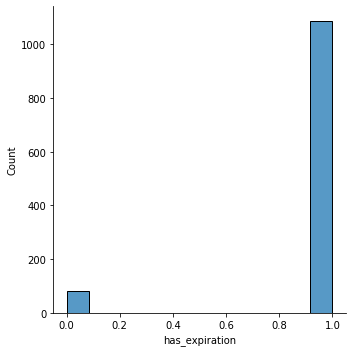

In [202]:
sns.displot(products.has_expiration)

In [24]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
products['category_combined_code'] = ordinal_encoder.fit_transform(products[['category_combined']]).astype(int)
products['product_id_code'] = ordinal_encoder.fit_transform(products[['product_id']]).astype(int)
products.head()

,product_id,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code
0,5d0794866885630014681b97,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29
1,5cebfa8d0b259700045dc8b2,Biscuit lait chocolat,GERBLÉ,270,3175680011534,230,g,"[{""text"": ""Farine de BLE 50,1%, sucre de canne...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},GERBLÉ Biscuit lait chocolat,True,epicerie_sucree biscuits_gateaux,1,16,9
2,5d0794866885630014681b9c,"Home - Serviettes 2 épaisseurs 32,5x32,5 cm rouge",DOMÉDIA,167,3250391451548,1,item,"[{""text"": ""Domédia à votre écoute au 0 800 008...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"DOMÉDIA Home - Serviettes 2 épaisseurs 32,5x32...",False,hygiene_maison hygiene_beaute,0,23,33
3,602a2d81304b800015a177ca,Oeuf Kinder Surprise x3,KINDER,105,8000500348956,60,g,[],"{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,chocolats_bonbons,{titres_restaurants},KINDER Oeuf Kinder Surprise x3,True,epicerie_sucree chocolats_bonbons,1,19,1143
4,602a2c983ddc3100158d6b06,Soupe légumes et vermicelles,LIEBIG,1065,3036811367787,1000,ml,[],"{""fr"": ""fr/food""}",epicerie_salee,https://storebox-api-public-production.s3.amaz...,soupes_croutons,{titres_restaurants},LIEBIG Soupe légumes et vermicelles,True,epicerie_salee soupes_croutons,1,15,1142


In [25]:
# (every word position is a feat, let us see)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def create_one_feat_per_word_in_str_column(df, colname):
  """
  Split the text col in a list of words, take len.
  Select max len, and then make a column for each position in that len. 
  If len of a word is as big as len, then insert empty string.
  Finally apply label encoder. 
  """
  df[f'{colname}_len'] = df[colname].apply(lambda x: len(x.split(' ')))
  for i in range(df[f'{colname}_len'].max()):
    df[f'{colname}_word_{i}'] = df[colname].apply(lambda x: x.split(' ')[i] if len(x.split(' ')) > i else ' ')
    df[f'{colname}_word_{i}'] = le.fit_transform(df[f'{colname}_word_{i}'])
  
  return df


In [26]:
products = create_one_feat_per_word_in_str_column(products, 'full_name')

In [27]:
products = create_one_feat_per_word_in_str_column(products, 'category_combined')

In [28]:
products.head()

,product_id,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1
0,5d0794866885630014681b97,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13
1,5cebfa8d0b259700045dc8b2,Biscuit lait chocolat,GERBLÉ,270,3175680011534,230,g,"[{""text"": ""Farine de BLE 50,1%, sucre de canne...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},GERBLÉ Biscuit lait chocolat,True,epicerie_sucree biscuits_gateaux,1,16,9,4,109,63,469,350,1,1,1,1,1,1,0,1,1,1,0,0,2,2,2
2,5d0794866885630014681b9c,"Home - Serviettes 2 épaisseurs 32,5x32,5 cm rouge",DOMÉDIA,167,3250391451548,1,item,"[{""text"": ""Domédia à votre écoute au 0 800 008...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"DOMÉDIA Home - Serviettes 2 épaisseurs 32,5x32...",False,hygiene_maison hygiene_beaute,0,23,33,9,79,215,3,244,21,401,18,101,127,1,0,1,1,1,0,0,2,3,13
3,602a2d81304b800015a177ca,Oeuf Kinder Surprise x3,KINDER,105,8000500348956,60,g,[],"{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,chocolats_bonbons,{titres_restaurants},KINDER Oeuf Kinder Surprise x3,True,epicerie_sucree chocolats_bonbons,1,19,1143,5,145,310,181,258,516,1,1,1,1,1,0,1,1,1,0,0,2,2,6
4,602a2c983ddc3100158d6b06,Soupe légumes et vermicelles,LIEBIG,1065,3036811367787,1000,ml,[],"{""fr"": ""fr/food""}",epicerie_salee,https://storebox-api-public-production.s3.amaz...,soupes_croutons,{titres_restaurants},LIEBIG Soupe légumes et vermicelles,True,epicerie_salee soupes_croutons,1,15,1142,5,165,410,477,397,511,1,1,1,1,1,0,1,1,1,0,0,2,1,26


In [29]:
######## LANGUAGE FEATURES ########
#source: https://www.datacamp.com/community/tutorials/fuzzy-string-python
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
      # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
      # insertions and/or substitutions
      # This is the minimum number of edits needed to convert string a to string b
      return distance[row][col]

In [30]:
products['levenshtein_dist'] = products[['category_combined', 'full_name']].apply(lambda x: levenshtein_ratio_and_distance(x[0], x[1]), axis=1)
products['levenshtein_dist_ratio'] = products[['category_combined', 'full_name']].apply(lambda x: levenshtein_ratio_and_distance(x[0], x[1], ratio_calc=True), axis=1)


In [31]:
products.head()

,product_id,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio
0,5d0794866885630014681b97,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766
1,5cebfa8d0b259700045dc8b2,Biscuit lait chocolat,GERBLÉ,270,3175680011534,230,g,"[{""text"": ""Farine de BLE 50,1%, sucre de canne...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},GERBLÉ Biscuit lait chocolat,True,epicerie_sucree biscuits_gateaux,1,16,9,4,109,63,469,350,1,1,1,1,1,1,0,1,1,1,0,0,2,2,2,27,0.333333
2,5d0794866885630014681b9c,"Home - Serviettes 2 épaisseurs 32,5x32,5 cm rouge",DOMÉDIA,167,3250391451548,1,item,"[{""text"": ""Domédia à votre écoute au 0 800 008...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"DOMÉDIA Home - Serviettes 2 épaisseurs 32,5x32...",False,hygiene_maison hygiene_beaute,0,23,33,9,79,215,3,244,21,401,18,101,127,1,0,1,1,1,0,0,2,3,13,48,0.209302
3,602a2d81304b800015a177ca,Oeuf Kinder Surprise x3,KINDER,105,8000500348956,60,g,[],"{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,chocolats_bonbons,{titres_restaurants},KINDER Oeuf Kinder Surprise x3,True,epicerie_sucree chocolats_bonbons,1,19,1143,5,145,310,181,258,516,1,1,1,1,1,0,1,1,1,0,0,2,2,6,32,0.253968
4,602a2c983ddc3100158d6b06,Soupe légumes et vermicelles,LIEBIG,1065,3036811367787,1000,ml,[],"{""fr"": ""fr/food""}",epicerie_salee,https://storebox-api-public-production.s3.amaz...,soupes_croutons,{titres_restaurants},LIEBIG Soupe légumes et vermicelles,True,epicerie_salee soupes_croutons,1,15,1142,5,165,410,477,397,511,1,1,1,1,1,0,1,1,1,0,0,2,1,26,30,0.276923


## Inventory (Not used anymore)

In [32]:
inventory_snapshots['year'] = pd.DatetimeIndex(inventory_snapshots['snapshot_date']).year
inventory_snapshots['month'] = pd.DatetimeIndex(inventory_snapshots['snapshot_date']).month
inventory_snapshots['date'] = pd.DatetimeIndex(inventory_snapshots['snapshot_date']).date 
inventory_snapshots['day'] = pd.DatetimeIndex(inventory_snapshots['snapshot_date']).day
inventory_snapshots['weekday'] = pd.DatetimeIndex(inventory_snapshots['snapshot_date']).weekday

In [33]:
inventory_snapshots_products = pd.merge(inventory_snapshots, products, left_on='product_id', right_on='product_id')
print(inventory_snapshots_products.shape)
inventory_snapshots_products.head()

(110828, 50)


,store_id,product_id,product_count,snapshot_date,capacity_inventory_snapshot,year,month,date,day,weekday,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio
0,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,3,2020-09-28 17:04:36,NaN,2020,9,2020-09-28,28,0,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3
1,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,3,2020-10-07 17:08:14,6.0,2020,10,2020-10-07,7,2,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3
2,5f60c3bbf4ff730004b46600,5eba8b6e0acf1b00048eef51,4,2020-10-07 17:08:14,6.0,2020,10,2020-10-07,7,2,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3
3,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,4,2020-09-29 17:06:32,NaN,2020,9,2020-09-29,29,1,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3
4,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,4,2020-10-08 17:03:29,6.0,2020,10,2020-10-08,8,3,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3


In [214]:
inventory_snapshots_products.product_id.nunique()

508

In [34]:
inventory_snapshots_products.loc[inventory_snapshots_products['capacity_inventory_snapshot'].isna()]['store_id'].unique()

array(['5f1198de8746ae00042869ba', '5f60c3bbf4ff730004b46600'],
      dtype=object)

In [35]:
inventory_snapshots_products['capacity_inventory_snapshot'] = inventory_snapshots_products['capacity_inventory_snapshot'].fillna(inventory_snapshots_products.groupby(["store_id", "product_id"])["capacity_inventory_snapshot"].transform("mean"))
inventory_snapshots_products.loc[inventory_snapshots_products['capacity_inventory_snapshot'].isna()]

,store_id,product_id,product_count,snapshot_date,capacity_inventory_snapshot,year,month,date,day,weekday,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio
13658,5f1198de8746ae00042869ba,5f119cbd8746ae0004286a2b,2,2020-09-28 17:04:36,NaN,2020,9,2020-09-28,28,0,Salade Saumon ASC Boulgour & Tzatziki,LE KIOSQUE A SANDWICHES,399,3700365097413,225,g,"[{""items"": [{""text"": ""9.7g\ndont acides gras s...","{""fr"": ""fr/food""}",restauration,https://storebox-api-public-production.s3.eu-w...,salades_entrees,{titres_restaurants},LE KIOSQUE A SANDWICHES Salade Saumon ASC Boul...,True,restauration salades_entrees,1,41,842,10,162,231,24,235,230,158,32,18,2,38,0,1,1,1,0,0,2,5,23,53,0.202247
13659,5f1198de8746ae00042869ba,5f119cbd8746ae0004286a2b,0,2020-09-29 17:06:32,NaN,2020,9,2020-09-29,29,1,Salade Saumon ASC Boulgour & Tzatziki,LE KIOSQUE A SANDWICHES,399,3700365097413,225,g,"[{""items"": [{""text"": ""9.7g\ndont acides gras s...","{""fr"": ""fr/food""}",restauration,https://storebox-api-public-production.s3.eu-w...,salades_entrees,{titres_restaurants},LE KIOSQUE A SANDWICHES Salade Saumon ASC Boul...,True,restauration salades_entrees,1,41,842,10,162,231,24,235,230,158,32,18,2,38,0,1,1,1,0,0,2,5,23,53,0.202247
13660,5f1198de8746ae00042869ba,5f119cbd8746ae0004286a2b,0,2020-09-30 17:01:50,NaN,2020,9,2020-09-30,30,2,Salade Saumon ASC Boulgour & Tzatziki,LE KIOSQUE A SANDWICHES,399,3700365097413,225,g,"[{""items"": [{""text"": ""9.7g\ndont acides gras s...","{""fr"": ""fr/food""}",restauration,https://storebox-api-public-production.s3.eu-w...,salades_entrees,{titres_restaurants},LE KIOSQUE A SANDWICHES Salade Saumon ASC Boul...,True,restauration salades_entrees,1,41,842,10,162,231,24,235,230,158,32,18,2,38,0,1,1,1,0,0,2,5,23,53,0.202247
55341,5f1198de8746ae00042869ba,5f119cbd8746ae0004286a33,0,2020-09-28 17:04:36,NaN,2020,9,2020-09-28,28,0,Yaourt brassé bio myrtille,MARIE MORIN,240,3372900900177,140,g,"[{""text"": ""lait entier origine France, prépara...","{""fr"": ""fr/food""}",produits_frais,https://storebox-api-public-production.s3.eu-w...,yaourts_compotes,"{titres_restaurants,dessert - menu traiteur,ac...",MARIE MORIN Yaourt brassé bio myrtille,True,produits_frais yaourts_compotes,1,35,850,6,188,272,355,323,293,315,1,1,1,1,0,1,1,1,0,0,2,4,31,31,0.318841
55342,5f1198de8746ae00042869ba,5f119cbd8746ae0004286a33,0,2020-09-29 17:06:32,NaN,2020,9,2020-09-29,29,1,Yaourt brassé bio myrtille,MARIE MORIN,240,3372900900177,140,g,"[{""text"": ""lait entier origine France, prépara...","{""fr"": ""fr/food""}",produits_frais,https://storebox-api-public-production.s3.eu-w...,yaourts_compotes,"{titres_restaurants,dessert - menu traiteur,ac...",MARIE MORIN Yaourt brassé bio myrtille,True,produits_frais yaourts_compotes,1,35,850,6,188,272,355,323,293,315,1,1,1,1,0,1,1,1,0,0,2,4,31,31,0.318841
59207,5f60c3bbf4ff730004b46600,5ecf75b2ae7a7400042167b1,0,2020-09-28 17:04:36,NaN,2020,9,2020-09-28,28,0,Grisbi Chocolat,GRISBI,187,8033102690062,150,g,"[{""text"": """", ""title"": ""Ingrédients""}, {""items...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},GRISBI Grisbi Chocolat,True,epicerie_sucree biscuits_gateaux,1,16,421,3,114,208,81,1,1,1,1,1,1,1,0,1,1,1,0,0,2,2,2,27,0.296296
59208,5f60c3bbf4ff730004b46600,5ecf75b2ae7a7400042167b1,4,2020-09-29 17:06:32,NaN,2020,9,2020-09-29,29,1,Grisbi Chocolat,GRISBI,1

In [36]:
inventory_snapshots_products['capacity_inventory_snapshot'] = inventory_snapshots_products['capacity_inventory_snapshot'].fillna(inventory_snapshots_products.groupby(["store_id", "category_combined"])["capacity_inventory_snapshot"].transform("mean"))
inventory_snapshots_products.loc[inventory_snapshots_products['capacity_inventory_snapshot'].isna()]

,store_id,product_id,product_count,snapshot_date,capacity_inventory_snapshot,year,month,date,day,weekday,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio


In [37]:
inventory_snapshots_products['capacity_inventory_snapshot'] = inventory_snapshots_products['capacity_inventory_snapshot'].astype(int)
inventory_snapshots_products.head()

,store_id,product_id,product_count,snapshot_date,capacity_inventory_snapshot,year,month,date,day,weekday,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio
0,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,3,2020-09-28 17:04:36,7,2020,9,2020-09-28,28,0,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3
1,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,3,2020-10-07 17:08:14,6,2020,10,2020-10-07,7,2,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3
2,5f60c3bbf4ff730004b46600,5eba8b6e0acf1b00048eef51,4,2020-10-07 17:08:14,6,2020,10,2020-10-07,7,2,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3
3,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,4,2020-09-29 17:06:32,7,2020,9,2020-09-29,29,1,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3
4,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,4,2020-10-08 17:03:29,6,2020,10,2020-10-08,8,3,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3


In [38]:
# define the missing inventory => sku opportunities
# capacity_inventory_snapshot - product_count
inventory_snapshots_products['diff_capacity_product_count'] = inventory_snapshots_products['capacity_inventory_snapshot'] - inventory_snapshots_products['product_count']
inventory_snapshots_products.head()

,store_id,product_id,product_count,snapshot_date,capacity_inventory_snapshot,year,month,date,day,weekday,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,diff_capacity_product_count
0,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,3,2020-09-28 17:04:36,7,2020,9,2020-09-28,28,0,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3,4
1,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,3,2020-10-07 17:08:14,6,2020,10,2020-10-07,7,2,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3,3
2,5f60c3bbf4ff730004b46600,5eba8b6e0acf1b00048eef51,4,2020-10-07 17:08:14,6,2020,10,2020-10-07,7,2,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3,2
3,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,4,2020-09-29 17:06:32,7,2020,9,2020-09-29,29,1,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3,3
4,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,4,2020-10-08 17:03:29,6,2020,10,2020-10-08,8,3,Granola extra cookies aux pépites de chocolat,LU,194,3017760756198,184,g,"[{""text"": ""Farine de _blé_ 34 %, chocolat 33,...","{""fr"": ""fr/food""}",epicerie_sucree,https://storebox-api-public-production.s3.eu-w...,biscuits_gateaux,{titres_restaurants},LU Granola extra cookies aux pépites de chocolat,True,epicerie_sucree biscuits_gateaux,1,16,379,8,175,205,435,365,287,346,174,94,1,1,0,1,1,1,0,0,2,2,2,41,0.3,2


## Invoiceables and invoiceable lines


In [39]:
days_train = list(range(1,32))

In [40]:
import itertools
def get_day_product_id_df(days_list, product_ids_list):
  days_product_ids_list = list(itertools.product(days_list, product_ids_list))
  df = pd.DataFrame(days_product_ids_list)
  df.columns = ['day', 'product_id']
  df['day_product_id'] = df['day'].astype(str) + '_' + df['product_id'].astype(str)
  return df


In [41]:
train_data = get_day_product_id_df(days_train, product_ids_list)
train_data

,day,product_id,day_product_id
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97
1,1,5cebfa8d0b259700045dc8b2,1_5cebfa8d0b259700045dc8b2
2,1,5d0794866885630014681b9c,1_5d0794866885630014681b9c
3,1,602a2d81304b800015a177ca,1_602a2d81304b800015a177ca
4,1,602a2c983ddc3100158d6b06,1_602a2c983ddc3100158d6b06
...,...,...,...
36203,31,5fd2007b3cd6510017b506e2,31_5fd2007b3cd6510017b506e2
36204,31,5fdc81817de7f70017351dc3,31_5fdc81817de7f70017351dc3
36205,31,5fdf6bbe949d860017567dc8,31_5fdf6bbe949d860017567dc8
36206,31,5fdf6c9b3479d3001700d21a,31_5fdf6c9b3479d3001700d21a


In [42]:
invoiceable_lines_combined = pd.merge(invoiceable_lines, invoiceables, left_on='invoiceable_id', right_on='invoiceable_id')
print(invoiceable_lines_combined.shape)
invoiceable_lines_combined.head()

(33060, 16)


,invoiceable_id,line_detail_index,amount,product_id,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label,created_at,customer_id,store_id,total_after_vat,total_before_vat,total_to_pay
0,5f294471bb1505000469d477,0,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:20:17,5d768c85d15280000488a0ba,5f1198de8746ae00042869ba,500,474,500
1,5f294471bb1505000469d477,1,250,5f119cbd8746ae0004286a26,False,False,True,False,fr/food,Product: LE KIOSQUE A SANDWICHES - CLUB ŒUF BI...,2020-08-04 13:20:17,5d768c85d15280000488a0ba,5f1198de8746ae00042869ba,500,474,500
2,5f294471bb1505000469d477,2,140,5f1ebfc1f66f080004a7243c,False,False,True,False,fr/food,Product: Muffy Muffins - Muffin myrtilles,2020-08-04 13:20:17,5d768c85d15280000488a0ba,5f1198de8746ae00042869ba,500,474,500
3,5f294543bb1505000469d48d,0,70,5ec4003f736e1800043e96f3,False,False,True,False,fr/food,CRISTALINE - BOISSON À L'EAU DE SOURCE ET JUS ...,2020-08-04 13:23:47,5de65f4b0d8add0004572f7e,5f1198de8746ae00042869ba,360,341,360
4,5f294543bb1505000469d48d,1,290,5f119cbd8746ae0004286a27,False,False,True,False,fr/food,LE KIOSQUE A SANDWICHES - WRAP DUO POULET PAR...,2020-08-04 13:23:47,5de65f4b0d8add0004572f7e,5f1198de8746ae00042869ba,360,341,360


In [43]:
# invoiceable_lines_combined = invoiceable_lines_combined.loc[invoiceable_lines_combined.amount > 0]
def get_item_count(amount, is_promotion):
  if (is_promotion):
    return 0
  if (amount < 0):
    return -1
  else:
    return 1

invoiceable_lines_combined['item_count_day'] = invoiceable_lines_combined.apply(lambda x: get_item_count(x['amount'], x['is_promotion_campaign']), axis=1)


In [44]:
invoiceable_lines_combined['day'] = pd.DatetimeIndex(invoiceable_lines_combined['created_at']).day

In [45]:
# targets_df = invoiceable_lines_combined.groupby(['day', 'product_id']).size().reset_index(name='count')
targets_df = invoiceable_lines_combined.groupby(['day', 'product_id']).agg({'item_count_day': ['sum'],'amount': ['mean']}).reset_index()
targets_df.columns = ['day', 'product_id', 'target', 'price_avg_daily']
targets_df 

,day,product_id,target,price_avg_daily
0,1,5cebfa8d0b259700045dc8a9,2,160.00000
1,1,5cebfa8d0b259700045dc8aa,2,160.00000
2,1,5cebfa8d0b259700045dc8b6,1,230.00000
3,1,5d0794866885630014681ba4,2,170.00000
4,1,5d0794866885630014681ba6,21,149.52381
...,...,...,...,...
7944,31,5fdf6819949d860017567da7,1,350.00000
7945,31,5fdf68e13479d3001700d1ef,1,360.00000
7946,31,5fdf6a2a3479d3001700d202,1,280.00000
7947,31,5fdf6c313479d3001700d20f,2,250.00000


In [46]:
invoiceable_lines_combined = pd.merge(invoiceable_lines_combined, targets_df, left_on=['day', 'product_id'], right_on=['day', 'product_id'])
# invoiceable_lines_combined = invoiceable_lines_combined.rename(columns={"count": "target"})
invoiceable_lines_combined.head()

,invoiceable_id,line_detail_index,amount,product_id,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label,created_at,customer_id,store_id,total_after_vat,total_before_vat,total_to_pay,item_count_day,day,target,price_avg_daily
0,5f294471bb1505000469d477,0,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:20:17,5d768c85d15280000488a0ba,5f1198de8746ae00042869ba,500,474,500,1,4,5,93.0
1,5f2945d9bb1505000469d492,1,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:26:17,5d7b63de25484a000498e53c,5f1198de8746ae00042869ba,900,853,900,1,4,5,93.0
2,5f2940cfbb1505000469d46c,0,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:04:47,5f293e782f76ae00046a76fb,5f1198de8746ae00042869ba,720,682,720,1,4,5,93.0
3,5f790be53864610004450e0f,2,120,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-10-04 01:40:21,5f7909b4a8e00c0004c467db,5f60c3bbf4ff730004b46600,1190,1085,1190,1,4,5,93.0
4,5ff2ea5f7b87b90004c72779,0,120,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - Eau aromatisée fraise framboise,2021-01-04 11:13:51,5f9a818496e2d000046560d1,5f60c3bbf4ff730004b46600,207,196,207,1,4,5,93.0


In [47]:
invoiceable_lines_combined['day_product_id'] = invoiceable_lines_combined['day'].astype(str) + '_' + invoiceable_lines_combined['product_id'].astype(str)

In [298]:
train_invoicables_lines_combined = pd.merge(train_data, invoiceable_lines_combined, left_on=['day', 'product_id', 'day_product_id'], right_on=['day', 'product_id', 'day_product_id'], how='left')

In [299]:
train_invoicables_lines_combined.head()

,day,product_id,day_product_id,invoiceable_id,line_detail_index,amount,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label,created_at,customer_id,store_id,total_after_vat,total_before_vat,total_to_pay,item_count_day,target,price_avg_daily
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5cebfa8d0b259700045dc8b2,1_5cebfa8d0b259700045dc8b2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,5d0794866885630014681b9c,1_5d0794866885630014681b9c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,602a2d81304b800015a177ca,1_602a2d81304b800015a177ca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,602a2c983ddc3100158d6b06,1_602a2c983ddc3100158d6b06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [300]:
train_invoicables_lines_combined.shape

(61319, 21)

In [301]:
train_invoicables_lines_combined = pd.merge(train_invoicables_lines_combined, products, left_on=['product_id'], right_on=['product_id'], how='inner')

In [302]:
train_invoicables_lines_combined.head(2)

,day,product_id,day_product_id,invoiceable_id,line_detail_index,amount,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label,created_at,customer_id,store_id,total_after_vat,total_before_vat,total_to_pay,item_count_day,target,price_avg_daily,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766


In [304]:
def fill_na_in_df(df, target_column, columns_list):
  for column in columns_list:
    print(column)
    df[target_column] = df[target_column].fillna(df.groupby([column])[target_column].transform('mean'))
  
  df[target_column] = df[target_column].fillna(0)
  return df

In [305]:
train_invoicables_lines_combined = fill_na_in_df(train_invoicables_lines_combined, 'target', ['day_product_id', 'product_id', 'category_combined', 'vat_id_by_country'])
train_invoicables_lines_combined['target'] = train_invoicables_lines_combined['target'].astype(int)
train_invoicables_lines_combined.head(2)

day_product_id
product_id
category_combined
vat_id_by_country


,day,product_id,day_product_id,invoiceable_id,line_detail_index,amount,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label,created_at,customer_id,store_id,total_after_vat,total_before_vat,total_to_pay,item_count_day,target,price_avg_daily,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766


In [306]:
val = pd.DataFrame(invoiceable_lines_combined[invoiceable_lines_combined['is_promotion_campaign'] == True][['product_id']].groupby('product_id').size()).reset_index()
val
val[val['product_id'] == '5fdc81817de7f70017351dc3']

,product_id,0


In [307]:
# make a feature of returned items
train_invoicables_lines_combined['returned_count'] = train_invoicables_lines_combined['product_id'].map(invoiceable_lines_combined[invoiceable_lines_combined['item_count_day'] < 0][['product_id', 'item_count_day']].groupby('product_id').item_count_day.sum())
train_invoicables_lines_combined['returned_count'] = train_invoicables_lines_combined['returned_count'].fillna(0)
train_invoicables_lines_combined['returned_count'] = train_invoicables_lines_combined['returned_count'].apply(lambda x: abs(x))

# make a feature of promotions
train_invoicables_lines_combined['promotion_count'] = train_invoicables_lines_combined['product_id'].map(invoiceable_lines_combined[invoiceable_lines_combined['is_promotion_campaign'] == True][['product_id']].groupby('product_id').size())
train_invoicables_lines_combined['promotion_count'] = train_invoicables_lines_combined['promotion_count'].fillna(0)


In [308]:
train_invoicables_lines_combined.head()

,day,product_id,day_product_id,invoiceable_id,line_detail_index,amount,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label,created_at,customer_id,store_id,total_after_vat,total_before_vat,total_to_pay,item_count_day,target,price_avg_daily,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,returned_count,promotion_count
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0
2,3,5d0794866885630014681b97,3_5d0794866885630014681b97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0
3,4,5d0794866885630014681b97,4_5d0794866885630014681b97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0
4,5,5d0794866885630014681b97,5_5d0794866885630014681b97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0


In [309]:
train_invoicables_lines_combined = train_invoicables_lines_combined.drop(columns=['invoiceable_id', 'amount', 'total_after_vat', 'total_before_vat', 'total_to_pay', 'line_detail_index', 'is_correction', 'is_discount', 'is_product', 'is_promotion_campaign', 'vat_id', 'label', 'customer_id','store_id',])

In [310]:
train_invoicables_lines_combined.head(2)

,day,product_id,day_product_id,created_at,item_count_day,target,price_avg_daily,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,returned_count,promotion_count
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,NaN,NaN,8,NaN,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,NaN,NaN,8,NaN,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0


In [311]:
# train_invoicables_lines_combined = fill_na_in_df(train_invoicables_lines_combined, 'total_after_vat', ['day_product_id', 'product_id', 'category_combined', 'vat_id_by_country'])
# train_invoicables_lines_combined = fill_na_in_df(train_invoicables_lines_combined, 'total_before_vat', ['day_product_id', 'product_id', 'category_combined', 'vat_id_by_country'])
# train_invoicables_lines_combined = fill_na_in_df(train_invoicables_lines_combined, 'total_to_pay', ['day_product_id', 'product_id', 'category_combined', 'vat_id_by_country'])
# train_invoicables_lines_combined = fill_na_in_df(train_invoicables_lines_combined, 'amount', ['day_product_id', 'product_id', 'category_combined', 'vat_id_by_country'])

# train_invoicables_lines_combined['price_avg_daily'] = train_invoicables_lines_combined['price_avg_daily'].fillna(train_invoicables_lines_combined.groupby(['product_id'])['price_avg_daily'].transform('mean') ).fillna(0)
# train_invoicables_lines_combined['item_count_day'] = train_invoicables_lines_combined['item_count_day'].fillna(train_invoicables_lines_combined.groupby(['product_id'])['item_count_day'].transform('mean') ).fillna(0)

train_invoicables_lines_combined = fill_na_in_df(train_invoicables_lines_combined, 'price_avg_daily', ['day_product_id', 'product_id', 'category_combined', 'vat_id_by_country'])
train_invoicables_lines_combined = fill_na_in_df(train_invoicables_lines_combined, 'item_count_day', ['day_product_id', 'product_id', 'category_combined', 'vat_id_by_country'])
train_invoicables_lines_combined['item_count_day'] = train_invoicables_lines_combined['item_count_day'].astype(int)

day_product_id
product_id
category_combined
vat_id_by_country
day_product_id
product_id
category_combined
vat_id_by_country


In [312]:
train_invoicables_lines_combined['year'] = pd.DatetimeIndex(train_invoicables_lines_combined['created_at']).year.fillna(2020).astype(int)
train_invoicables_lines_combined['month'] = pd.DatetimeIndex(train_invoicables_lines_combined['created_at']).month.fillna(8).astype(int)
# train_invoicables_lines_combined['date'] = pd.DatetimeIndex(train_invoicables_lines_combined['created_at']).date 
# It is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6.
train_invoicables_lines_combined['weekday'] = pd.DatetimeIndex(train_invoicables_lines_combined['created_at']).weekday.fillna(5).astype(int)
train_invoicables_lines_combined

,day,product_id,day_product_id,created_at,item_count_day,target,price_avg_daily,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,returned_count,promotion_count,year,month,weekday
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,NaN,0,8,268.033360,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,NaN,0,8,268.033360,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
2,3,5d0794866885630014681b97,3_5d0794866885630014681b97,NaN,0,8,268.033360,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
3,4,5d0794866885630014681b97,4_5d0794866885630014681b97,NaN,0,8,268.033360,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
4,5,5d0794866885630014681b97,5_5d0794866885630014681b97,NaN,0,8,268.033360,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61314,28,5fdf6d023479d3001700d226,28_5fdf6d023479d3001700d226,NaN,0,1,238.636364,Dos de Colin d'Alaska sauce crème citron aneth...,Agis,359,3366760044485,320,g,"[{""items"": [{""text"": ""5.9g\ndont acides gras s...","{""fr"": ""fr/food""}",restauration,https://storebox-api-public-production.s3.eu-w...,plats_cuisines_traiteur,"{Menu traiteur,titres_restaurants,plat - menu ...",Agis Dos de Colin d'Alaska sauce crème citron ...,True,restauration plats_cuisines_traiteur,1,39,1110,14,16,157,415,81,345,363,169,98,59,98,30,22,19,12,0,0,2,5,20,64,0.324786,0.0,4.

In [313]:
train_invoicables_lines_combined = train_invoicables_lines_combined.drop(columns=['created_at'])

In [529]:
# vat_id_map = train_invoicables_lines_combined.groupby(['product_id'])['vat_id']
# train_invoicables_lines_combined['label'] = train_invoicables_lines_combined['label'].fillna(train_invoicables_lines_combined.groupby(['product_id'])['label'].first())
# train_invoicables_lines_combined['vat_id'] = train_invoicables_lines_combined['vat_id'].fillna(train_invoicables_lines_combined.groupby(['product_id'])['vat_id'].first())

In [538]:
# nan_map = train_invoicables_lines_combined.dropna().set_index('product_id').to_dict()['label']
# train_invoicables_lines_combined['label'] = train_invoicables_lines_combined['product_id'].map(nan_map)
# train_invoicables_lines_combined

,day,product_id,day_product_id,vat_id,label,target,year,month,weekday
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,NaN,NaN,4,2020,8,5
1,1,5cebfa8d0b259700045dc8b2,1_5cebfa8d0b259700045dc8b2,NaN,Gerblé - Biscuit lait chocolat,2,2020,8,5
2,1,5d0794866885630014681b9c,1_5d0794866885630014681b9c,NaN,NaN,4,2020,8,5
3,1,602a2d81304b800015a177ca,1_602a2d81304b800015a177ca,NaN,NaN,4,2020,8,5
4,1,602a2c983ddc3100158d6b06,1_602a2c983ddc3100158d6b06,NaN,NaN,4,2020,8,5
...,...,...,...,...,...,...,...,...,...
55447,31,5fdc81817de7f70017351dc3,31_5fdc81817de7f70017351dc3,fr/food,Bonne Maman - Petits cookies aux pépites de ch...,2,2021,1,6
55448,31,5fdc81817de7f70017351dc3,31_5fdc81817de7f70017351dc3,fr/food,Bonne Maman - Petits cookies aux pépites de ch...,2,2021,1,6
55449,31,5fdf6bbe949d860017567dc8,31_5fdf6bbe949d860017567dc8,NaN,Agis - 6 Gyozas aux crevettes 20g,1,2020,8,5
55450,31,5fdf6c9b3479d3001700d21a,31_5fdf6c9b3479d3001700d21a,fr/food,Agis - 6 Mini nems porc 30g + sauce,1,2021,1,6


In [314]:
invoiceable_lines_combined.customer_id.nunique()

1741

In [315]:
invoiceable_lines_combined.shape

(33060, 21)

In [63]:
all_data = pd.merge(invoiceable_lines_combined, products, left_on=['product_id'], right_on=['product_id'], how='inner' )

In [64]:
all_data.shape

(33060, 61)

In [65]:
all_data.head()

,invoiceable_id,line_detail_index,amount,product_id,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label,created_at,customer_id,store_id,total_after_vat,total_before_vat,total_to_pay,item_count_day,day,target,price_avg_daily,day_product_id,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio
0,5f294471bb1505000469d477,0,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:20:17,5d768c85d15280000488a0ba,5f1198de8746ae00042869ba,500,474,500,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,1,2,853,6,31,229,133,294,377,268,1,1,1,1,0,1,1,1,0,0,2,0,10,35,0.259259
1,5f2945d9bb1505000469d492,1,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:26:17,5d7b63de25484a000498e53c,5f1198de8746ae00042869ba,900,853,900,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,1,2,853,6,31,229,133,294,377,268,1,1,1,1,0,1,1,1,0,0,2,0,10,35,0.259259
2,5f2940cfbb1505000469d46c,0,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:04:47,5f293e782f76ae00046a76fb,5f1198de8746ae00042869ba,720,682,720,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,1,2,853,6,31,229,133,294,377,268,1,1,1,1,0,1,1,1,0,0,2,0,10,35,0.259259
3,5f790be53864610004450e0f,2,120,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-10-04 01:40:21,5f7909b4a8e00c0004c467db,5f60c3bbf4ff730004b46600,1190,1085,1190,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,1,2,853,6,31,229,133,294,377,268,1,1,1,1,0,1,1,1,0,0,2,0,10,35,0.259259
4,5ff2ea5f7b87b90004c72779,0,120,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - Eau aromatisée fraise framboise,2021-01-04 11:13:51,5f9a818496e2d000046560d1,5f60c3bbf4ff730004b46600,207,196,207,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu 

In [316]:
train_all_data = train_invoicables_lines_combined.copy()

In [317]:
train_all_data.head()

,day,product_id,day_product_id,item_count_day,target,price_avg_daily,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,returned_count,promotion_count,year,month,weekday
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
2,3,5d0794866885630014681b97,3_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
3,4,5d0794866885630014681b97,4_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
4,5,5d0794866885630014681b97,5_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5


## test code for inventory (not used anymore)

In [68]:
print(inventory_snapshots.shape)
inventory_snapshots.head()

(110828, 10)


,store_id,product_id,product_count,snapshot_date,capacity_inventory_snapshot,year,month,date,day,weekday
0,5f1198de8746ae00042869ba,5eba8b6e0acf1b00048eef51,3,2020-09-28 17:04:36,NaN,2020,9,2020-09-28,28,0
1,5f1198de8746ae00042869ba,5f10761c34250d00047bd2c0,4,2020-09-28 17:04:36,NaN,2020,9,2020-09-28,28,0
2,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8b3,7,2020-09-28 17:04:36,NaN,2020,9,2020-09-28,28,0
3,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8b6,3,2020-09-28 17:04:36,NaN,2020,9,2020-09-28,28,0
4,5f1198de8746ae00042869ba,5ecf7ebfe624c40004a394e3,3,2020-09-28 17:04:36,NaN,2020,9,2020-09-28,28,0


In [69]:
inventory_snapshots.groupby(['store_id', 'product_id'])['capacity_inventory_snapshot'].agg(['sum','count', 'mean']).reset_index()

,store_id,product_id,sum,count,mean
0,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8a9,598.0,93,6.430108
1,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8aa,790.0,125,6.320000
2,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8ac,152.0,36,4.222222
3,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8ad,918.0,127,7.228346
4,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8b1,400.0,73,5.479452
...,...,...,...,...,...
1958,5fe3228d8babb6001700452b,5fdf6d023479d3001700d226,180.0,35,5.142857
1959,5fe3228d8babb6001700452b,5fe49ae090093a00172429e8,290.0,35,8.285714
1960,5fe3228d8babb6001700452b,5ff2ce582f740d0017a91639,122.0,21,5.809524
1961,5fe3228d8babb6001700452b,5ffd76620147ec001767cea7,100.0,10,10.000000


In [70]:
inventory_snapshots.loc[(inventory_snapshots['store_id'] == '5f1198de8746ae00042869ba') & (inventory_snapshots['product_id'] == '5cebfa8d0b259700045dc8a9')].sort_values(['capacity_inventory_snapshot'])

,store_id,product_id,product_count,snapshot_date,capacity_inventory_snapshot,year,month,date,day,weekday
14,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8a9,5,2020-10-07 17:08:14,6.0,2020,10,2020-10-07,7,2
51243,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8a9,2,2020-12-11 17:01:07,6.0,2020,12,2020-12-11,11,4
50291,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8a9,2,2020-12-10 17:00:33,6.0,2020,12,2020-12-10,10,3
49339,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8a9,2,2020-12-09 17:08:07,6.0,2020,12,2020-12-09,9,2
48386,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8a9,1,2020-12-08 17:05:46,6.0,2020,12,2020-12-08,8,1
...,...,...,...,...,...,...,...,...,...,...
24492,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8a9,3,2020-11-06 17:02:48,8.0,2020,11,2020-11-06,6,4
23729,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8a9,4,2020-11-05 17:03:08,8.0,2020,11,2020-11-05,5,3
22966,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8a9,3,2020-11-04 17:03:43,8.0,2020,11,2020-11-04,4,2
36535,5f1198de8746ae00042869ba,5cebfa8d0b259700045dc8a9,2,2020-11-22 17:04:35,8.0,2020,11,2020-11-22,22,6


In [71]:
all_data_with_inventory = pd.merge(all_data, inventory_snapshots, left_on=['store_id', 'product_id', 'month', 'day'], right_on=['store_id', 'product_id', 'month', 'day'], how='left')

KeyError: ignored

In [167]:
all_data_with_inventory.shape

(33116, 44)

In [180]:
inventory_snapshots.loc[(inventory_snapshots['store_id'] =='5f1198de8746ae00042869ba') & (inventory_snapshots['product_id'] == '5f119cbd8746ae0004286a36') & (inventory_snapshots.month == 8) & (inventory_snapshots.day == 4)]

,store_id,product_id,product_count,snapshot_date,capacity_inventory_snapshot,year,month,date,day,weekday


In [183]:
all_data_with_inventory.isnull().sum()

invoiceable_id                    0
line_detail_index                 0
amount                            0
product_id                        0
is_correction                     0
is_discount                       0
is_product                        0
is_promotion_campaign             0
vat_id                            0
label                             0
created_at                        0
customer_id                       0
store_id                          0
total_after_vat                   0
total_before_vat                  0
total_to_pay                      0
year_x                            0
month                             0
date_x                            0
day                               0
weekday_x                         0
name                              0
brand                             0
weight                            0
barcode                           0
capacity_product                  0
capacity_unit                     0
information                 

# Data visualization

In [126]:
products.shape

(1168, 18)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


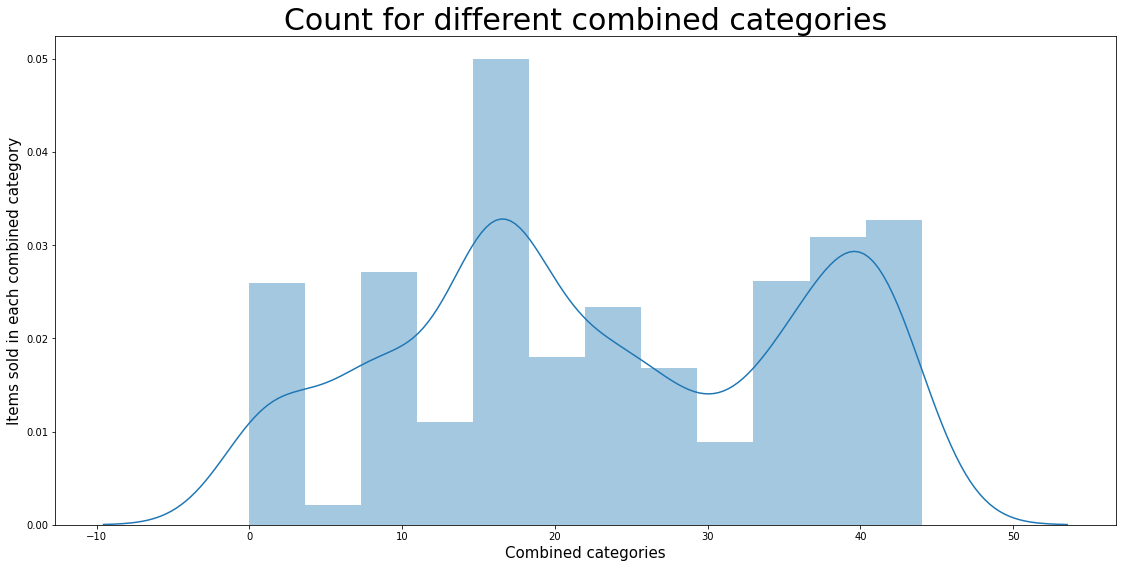

In [150]:

plt.rcParams['figure.figsize'] = (19, 9)
# sns.distplot(products['category_combined_code'], products['product_id_code'], palette = 'colorblind')
sns.distplot(products['category_combined_code'])
plt.title('Count for different combined categories', fontsize = 30)
plt.xlabel('Combined categories', fontsize = 15)
plt.ylabel('Items sold in each combined category', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


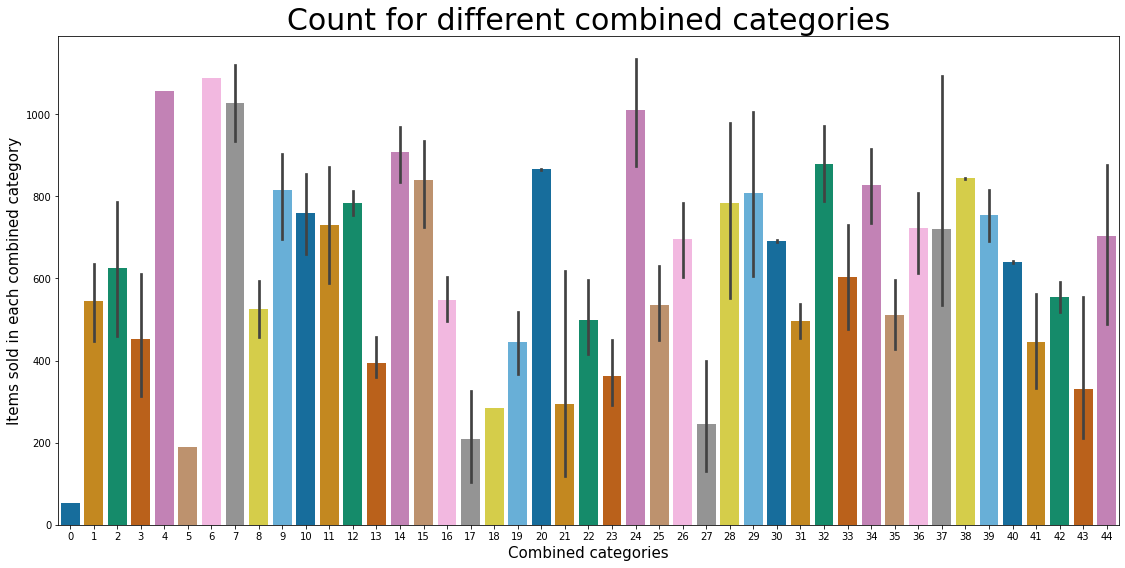

In [143]:
# looking at the number of different categories

plt.rcParams['figure.figsize'] = (19, 9)
sns.barplot(products['category_combined_code'], products['product_id_code'], palette = 'colorblind')
plt.title('Count for different combined categories', fontsize = 30)
plt.xlabel('Combined categories', fontsize = 15)
plt.ylabel('Items sold in each combined category', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


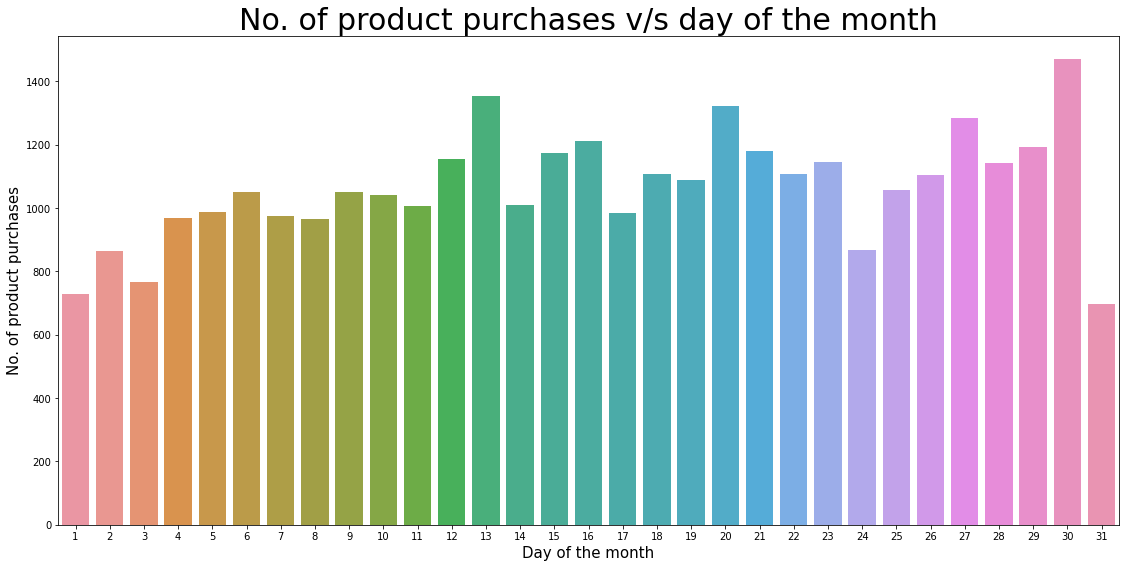

In [148]:
# having a look at the distribution of item sold per day

plt.rcParams['figure.figsize'] = (19, 9)
sns.countplot(invoiceable_lines_combined['day'])
plt.title('No. of product purchases v/s day of the month', fontsize = 30)
plt.xlabel('Day of the month', fontsize = 15)
plt.ylabel('No. of product purchases', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


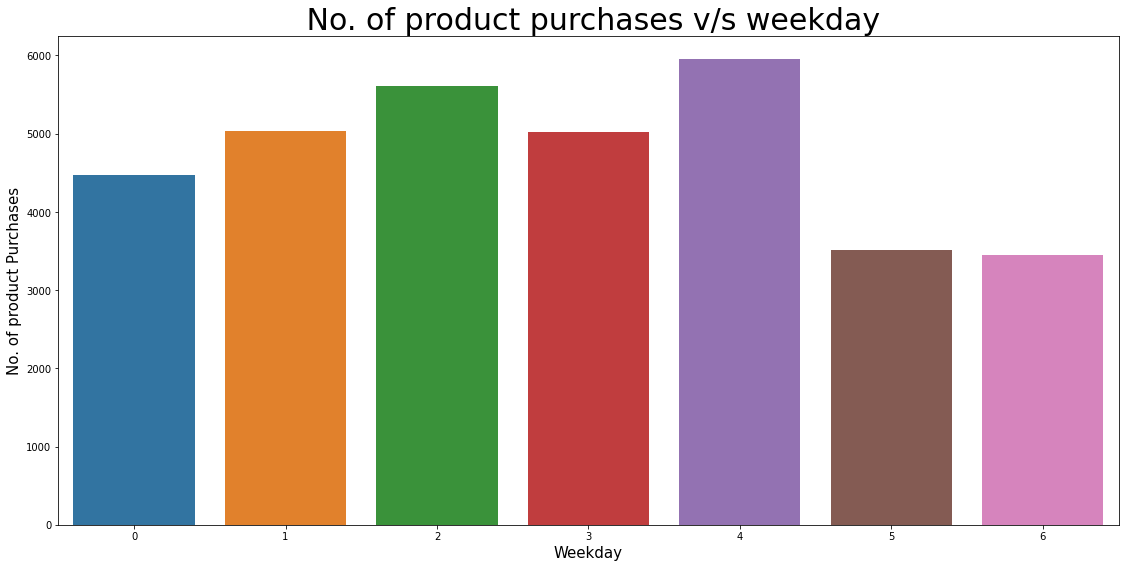

In [147]:
# having a look at the distribution of item sold per weekday 
# so on sunday, monday etc..

plt.rcParams['figure.figsize'] = (19, 9)
sns.countplot(invoiceable_lines_combined['weekday'])
plt.title(' No. of product purchases v/s weekday', fontsize = 30)
plt.xlabel('Weekday', fontsize = 15)
plt.ylabel('No. of product Purchases', fontsize = 15)
plt.show()

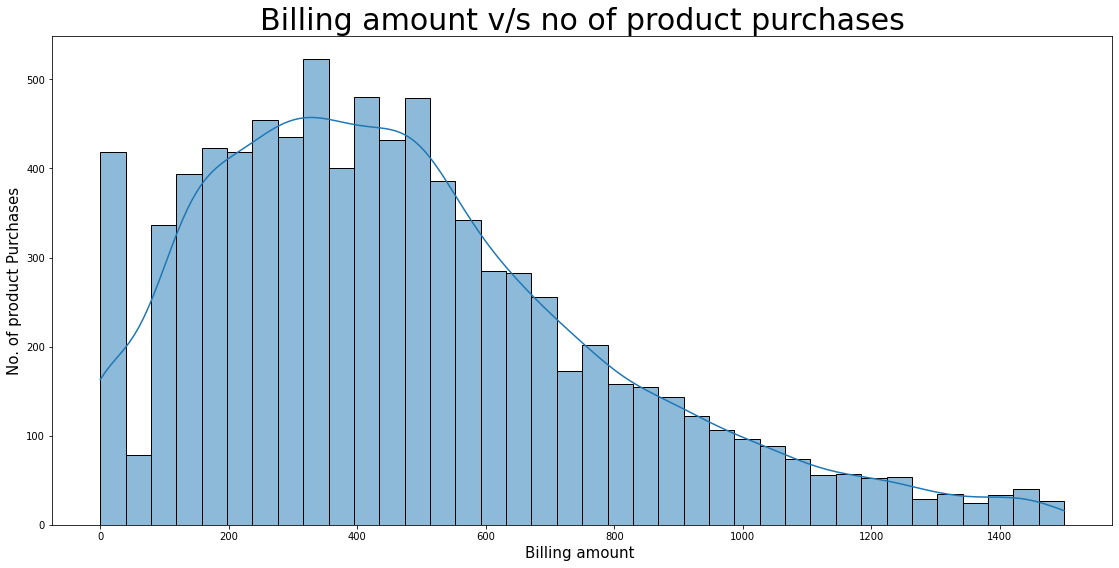

In [144]:
# having a look at the distribution of item sold per weekday 
# so on sunday, monday etc..

plt.rcParams['figure.figsize'] = (19, 9)
# sns.displot(invoiceable_lines_combined['total_to_pay'])
sns.histplot(invoiceables.loc[(invoiceables.total_to_pay >= 0) & (invoiceables.total_to_pay <= 1500)]['total_to_pay'], kde=True)
plt.title('Billing amount v/s no of product purchases', fontsize = 30)
plt.xlabel('Billing amount ', fontsize = 15)
plt.ylabel('No. of product Purchases', fontsize = 15)
plt.show()

In [202]:
all_data.store_id.nunique()

4

In [204]:
all_data.head()

,invoiceable_id,line_detail_index,amount,product_id,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label,created_at,customer_id,store_id,total_after_vat,total_before_vat,total_to_pay,year,month,date,day,weekday,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,category_combined_code,product_id_code
0,5f294471bb1505000469d477,0,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:20:17,5d768c85d15280000488a0ba,5f1198de8746ae00042869ba,500,474,500,2020,8,2020-08-04,4,1,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,2,853
1,5f2a89b50e8b320004d7735b,1,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-05 12:28:05,5e6f56c15f61950004b439b4,5f1198de8746ae00042869ba,650,616,650,2020,8,2020-08-05,5,2,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,2,853
2,5f2945d9bb1505000469d492,1,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:26:17,5d7b63de25484a000498e53c,5f1198de8746ae00042869ba,900,853,900,2020,8,2020-08-04,4,1,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,2,853
3,5f2be988ebe32800048d4f19,1,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-06 13:29:12,5d7b63de25484a000498e53c,5f1198de8746ae00042869ba,485,460,485,2020,8,2020-08-06,6,3,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,2,853
4,5f2be988ebe32800048d4f19,5,-11,5f119cbd8746ae0004286a36,False,False,False,True,fr/food,MENU CLASSIQUE : 10 % de réduction sur une sél...,2020-08-06 13:29:12,5d7b63de25484a000498e53c,5f1198de8746ae00042869ba,485,460,485,2020,8,2020-08-06,6,3,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,2,853


In [209]:
all_data = all_data.loc[all_data['amount'] > 0]

In [210]:
all_data.shape

(27193, 38)

In [205]:
all_data.category.unique()

array(['boissons', 'restauration', 'epicerie_sucree', 'epicerie_salee',
       'produits_frais', 'hygiene_maison'], dtype=object)

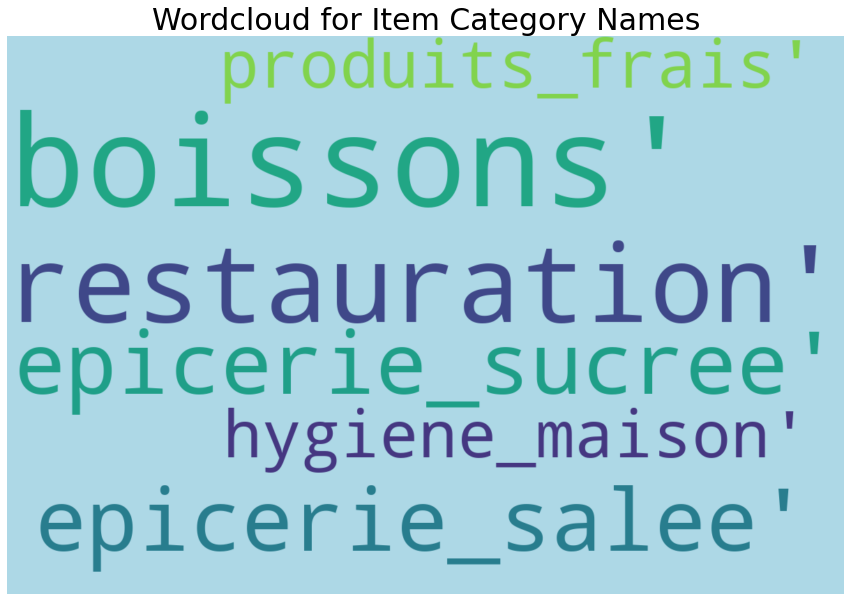

In [206]:
# making a word cloud for categoriy name
from wordcloud import WordCloud
from wordcloud import STOPWORDS

plt.rcParams['figure.figsize'] = (15, 12)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightblue',
                      max_words = 200, 
                     width = 1200,
                     height = 800,
                     random_state = 42).generate(str(all_data['category'].unique()))


plt.title('Wordcloud for Category Names', fontsize = 30)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')

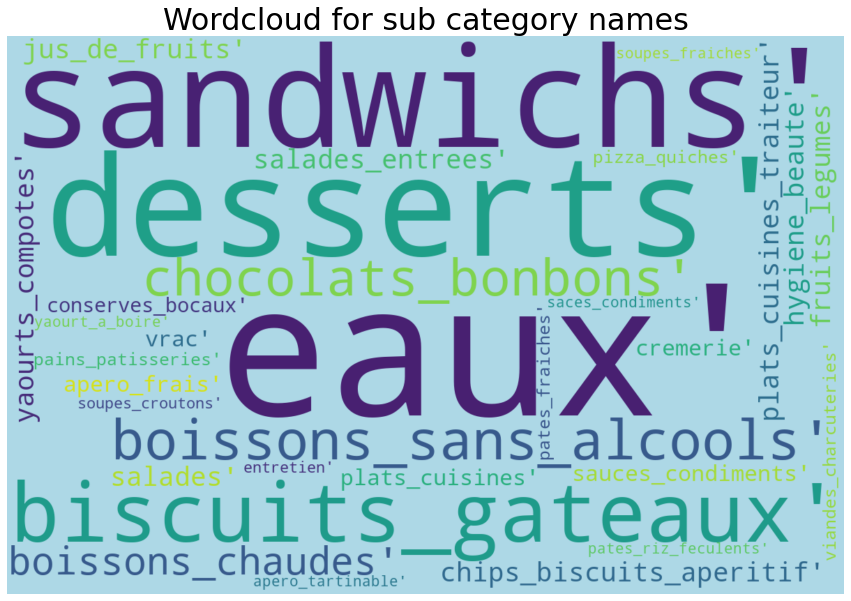

In [207]:
# making a word cloud for categoriy name
from wordcloud import WordCloud
from wordcloud import STOPWORDS

plt.rcParams['figure.figsize'] = (15, 12)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightblue',
                      max_words = 200, 
                     width = 1200,
                     height = 800,
                     random_state = 42).generate(str(all_data['sub_category'].unique()))


plt.title('Wordcloud for sub category names', fontsize = 30)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')

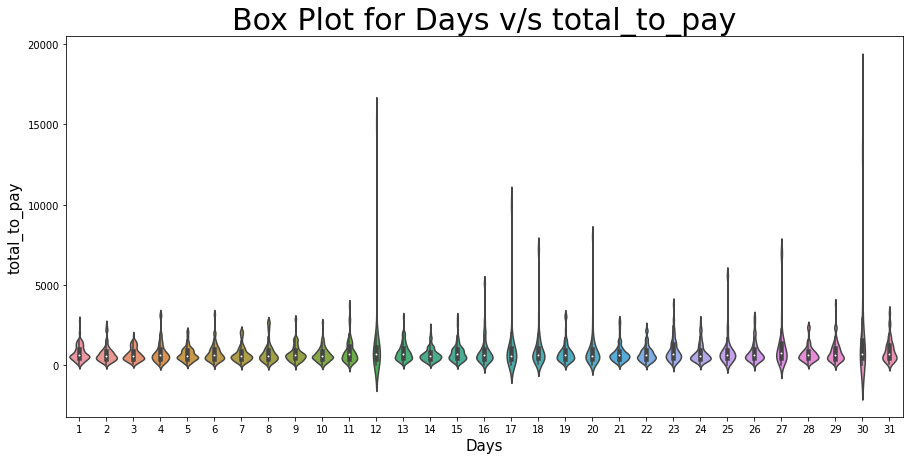

In [208]:
# plotting a box plot for itemprice and item-cnt-day

plt.rcParams['figure.figsize'] = (15, 7)
sns.violinplot(x = all_data['day'], y = all_data['total_to_pay'])
plt.title('Box Plot for Days v/s total_to_pay', fontsize = 30)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('total_to_pay', fontsize = 15)
plt.show()

# Build the train and test set


## Train set

### statistics on train all data

In [318]:
all_data.head()

,invoiceable_id,line_detail_index,amount,product_id,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label,created_at,customer_id,store_id,total_after_vat,total_before_vat,total_to_pay,item_count_day,day,target,price_avg_daily,day_product_id,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio
0,5f294471bb1505000469d477,0,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:20:17,5d768c85d15280000488a0ba,5f1198de8746ae00042869ba,500,474,500,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,1,2,853,6,31,229,133,294,377,268,1,1,1,1,0,1,1,1,0,0,2,0,10,35,0.259259
1,5f2945d9bb1505000469d492,1,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:26:17,5d7b63de25484a000498e53c,5f1198de8746ae00042869ba,900,853,900,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,1,2,853,6,31,229,133,294,377,268,1,1,1,1,0,1,1,1,0,0,2,0,10,35,0.259259
2,5f2940cfbb1505000469d46c,0,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:04:47,5f293e782f76ae00046a76fb,5f1198de8746ae00042869ba,720,682,720,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,1,2,853,6,31,229,133,294,377,268,1,1,1,1,0,1,1,1,0,0,2,0,10,35,0.259259
3,5f790be53864610004450e0f,2,120,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-10-04 01:40:21,5f7909b4a8e00c0004c467db,5f60c3bbf4ff730004b46600,1190,1085,1190,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,1,2,853,6,31,229,133,294,377,268,1,1,1,1,0,1,1,1,0,0,2,0,10,35,0.259259
4,5ff2ea5f7b87b90004c72779,0,120,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - Eau aromatisée fraise framboise,2021-01-04 11:13:51,5f9a818496e2d000046560d1,5f60c3bbf4ff730004b46600,207,196,207,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu 

In [319]:
all_data.head()

,invoiceable_id,line_detail_index,amount,product_id,is_correction,is_discount,is_product,is_promotion_campaign,vat_id,label,created_at,customer_id,store_id,total_after_vat,total_before_vat,total_to_pay,item_count_day,day,target,price_avg_daily,day_product_id,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio
0,5f294471bb1505000469d477,0,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:20:17,5d768c85d15280000488a0ba,5f1198de8746ae00042869ba,500,474,500,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,1,2,853,6,31,229,133,294,377,268,1,1,1,1,0,1,1,1,0,0,2,0,10,35,0.259259
1,5f2945d9bb1505000469d492,1,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:26:17,5d7b63de25484a000498e53c,5f1198de8746ae00042869ba,900,853,900,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,1,2,853,6,31,229,133,294,377,268,1,1,1,1,0,1,1,1,0,0,2,0,10,35,0.259259
2,5f2940cfbb1505000469d46c,0,110,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-08-04 13:04:47,5f293e782f76ae00046a76fb,5f1198de8746ae00042869ba,720,682,720,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,1,2,853,6,31,229,133,294,377,268,1,1,1,1,0,1,1,1,0,0,2,0,10,35,0.259259
3,5f790be53864610004450e0f,2,120,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - EAU AROMATISEE FRAISE FRAMBOISE,2020-10-04 01:40:21,5f7909b4a8e00c0004c467db,5f60c3bbf4ff730004b46600,1190,1085,1190,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu traiteur,bo...",BLUE KELD Eau aromatisée fraise framboise,True,boissons eaux,1,2,853,6,31,229,133,294,377,268,1,1,1,1,0,1,1,1,0,0,2,0,10,35,0.259259
4,5ff2ea5f7b87b90004c72779,0,120,5f119cbd8746ae0004286a36,False,False,True,False,fr/food,BLUE KELD - Eau aromatisée fraise framboise,2021-01-04 11:13:51,5f9a818496e2d000046560d1,5f60c3bbf4ff730004b46600,207,196,207,1,4,5,93.0,4_5f119cbd8746ae0004286a36,Eau aromatisée fraise framboise,BLUE KELD,534,5026356000421,500,ml,"[{""items"": [{""text"": ""0.5g\ndont acides gras s...","{""fr"": ""fr/food""}",boissons,https://storebox-api-public-production.s3.eu-w...,eaux,"{titres_restaurants,boisson - menu 

False    27193
Name: is_correction, dtype: int64


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


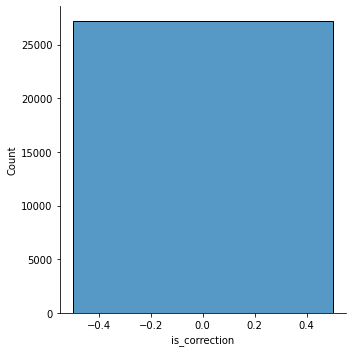

In [358]:
# print(all_data.is_correction.value_counts())
# sns.displot(all_data.is_correction)

False    27179
True        14
Name: is_discount, dtype: int64


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


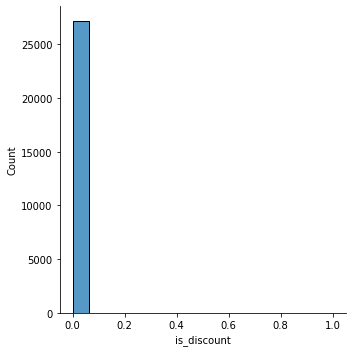

In [359]:
# print(all_data.is_discount.value_counts())
# sns.displot(all_data.is_discount)

False    27193
Name: is_promotion_campaign, dtype: int64


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


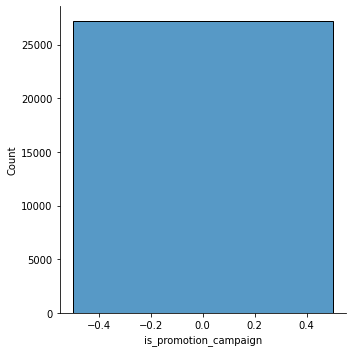

In [361]:
# print(all_data.is_promotion_campaign.value_counts())
# sns.displot(all_data.is_promotion_campaign)

True     27179
False       14
Name: is_product, dtype: int64


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


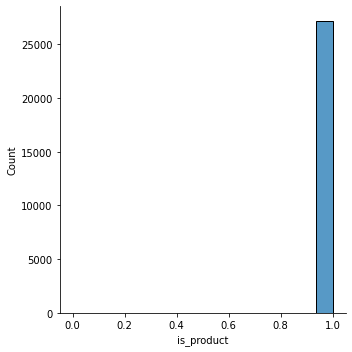

In [362]:
# print(all_data.is_product.value_counts())
# sns.displot(all_data.is_product)

### Train all data


In [320]:
train_all_data.head()

,day,product_id,day_product_id,item_count_day,target,price_avg_daily,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,returned_count,promotion_count,year,month,weekday
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
2,3,5d0794866885630014681b97,3_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
3,4,5d0794866885630014681b97,4_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5
4,5,5d0794866885630014681b97,5_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5


In [321]:
train_all_data['vat'] = train_all_data['vat_id_by_country'].apply(lambda x: 0.055 if ('fr/food' in x) else 0.2)
# all_data['high_vat'] = all_data['vat'].apply(lambda x: 0 if (x.str'fr/food') else 1 )
# add feature for confinement
train_all_data['is_confinement'] = train_all_data['month'].apply(lambda x: 1 if (x == 11) else 0)
train_all_data['is_summer'] = train_all_data['month'].apply(lambda x : 1 if (x == 8) else 0)
train_all_data['is_weekend'] = train_all_data['weekday'].apply(lambda x : 1 if (x > 4) else 0)

In [322]:
train_all_data.loc[train_all_data['vat'] > 0.1].head()

,day,product_id,day_product_id,item_count_day,target,price_avg_daily,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,returned_count,promotion_count,year,month,weekday,vat,is_confinement,is_summer,is_weekend
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5,0.2,0,1,1
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5,0.2,0,1,1
2,3,5d0794866885630014681b97,3_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5,0.2,0,1,1
3,4,5d0794866885630014681b97,4_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5,0.2,0,1,1
4,5,5d0794866885630014681b97,5_5d0794866885630014681b97,0,8,268.03336,"Brosse à dents medium , Global Protection",LABELL,44,3250391648665,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5,0.2,0,1,1


In [323]:
train_all_data.columns

Index(['day', 'product_id', 'day_product_id', 'item_count_day', 'target',
       'price_avg_daily', 'name', 'brand', 'weight', 'barcode',
       'capacity_product', 'capacity_unit', 'information', 'vat_id_by_country',
       'category', 'product_image_url', 'sub_category', 'tags', 'full_name',
       'has_expiration', 'category_combined', 'has_expiration_int',
       'category_combined_code', 'product_id_code', 'full_name_len',
       'full_name_word_0', 'full_name_word_1', 'full_name_word_2',
       'full_name_word_3', 'full_name_word_4', 'full_name_word_5',
       'full_name_word_6', 'full_name_word_7', 'full_name_word_8',
       'full_name_word_9', 'full_name_word_10', 'full_name_word_11',
       'full_name_word_12', 'full_name_word_13', 'full_name_word_14',
       'full_name_word_15', 'category_combined_len',
       'category_combined_word_0', 'category_combined_word_1',
       'levenshtein_dist', 'levenshtein_dist_ratio', 'returned_count',
       'promotion_count', 'year', 'month'

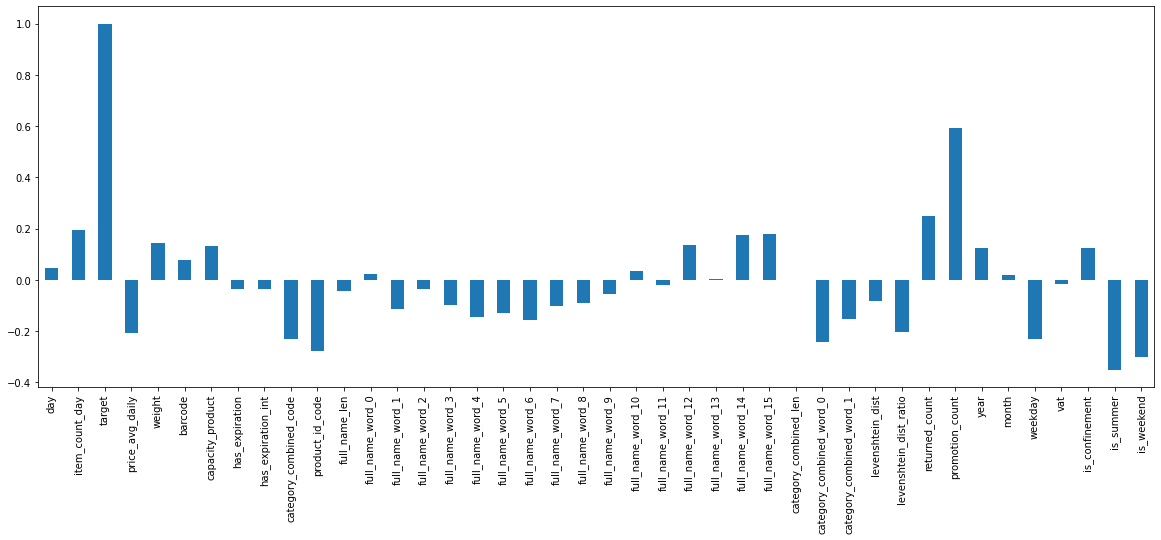

In [377]:
train_all_data.corr()['target'].plot(x='index', y='target', kind='bar', figsize=(20,7))

In [325]:
train_all_data = downcast_dtypes(train_all_data)

In [326]:
train_all_data.head()

,day,product_id,day_product_id,item_count_day,target,price_avg_daily,name,brand,weight,barcode,capacity_product,capacity_unit,information,vat_id_by_country,category,product_image_url,sub_category,tags,full_name,has_expiration,category_combined,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,returned_count,promotion_count,year,month,weekday,vat,is_confinement,is_summer,is_weekend
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,0,8,268.033356,"Brosse à dents medium , Global Protection",LABELL,44,-898594407,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5,0.2,0,1,1
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,0,8,268.033356,"Brosse à dents medium , Global Protection",LABELL,44,-898594407,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5,0.2,0,1,1
2,3,5d0794866885630014681b97,3_5d0794866885630014681b97,0,8,268.033356,"Brosse à dents medium , Global Protection",LABELL,44,-898594407,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5,0.2,0,1,1
3,4,5d0794866885630014681b97,4_5d0794866885630014681b97,0,8,268.033356,"Brosse à dents medium , Global Protection",LABELL,44,-898594407,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5,0.2,0,1,1
4,5,5d0794866885630014681b97,5_5d0794866885630014681b97,0,8,268.033356,"Brosse à dents medium , Global Protection",LABELL,44,-898594407,1,item,"[{""text"": ""Conseil pour une bonne hygiène bucc...","{""fr"": ""fr/default""}",hygiene_maison,https://storebox-api-public-production.s3.eu-w...,hygiene_beaute,{},"LABELL Brosse à dents medium , Global Protection",False,hygiene_maison hygiene_beaute,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,2020,8,5,0.2,0,1,1


In [328]:
train_all_data_dropped = train_all_data.drop(columns=['name', 'item_count_day', 'full_name', 'year', 'brand', 'weight', 'barcode', 'capacity_product', 'capacity_unit', 'information', 'vat_id_by_country', 'has_expiration', 'category', 'product_image_url', 'sub_category', 'tags', 'category_combined'])

In [767]:
# train_all_data = train_all_data.drop(columns=['full_name'])
# train_all_data = train_all_data.drop(columns=['item_count_day'])


In [329]:
train_all_data_dropped.head()

,day,product_id,day_product_id,target,price_avg_daily,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,returned_count,promotion_count,month,weekday,vat,is_confinement,is_summer,is_weekend
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,8,268.033356,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,8,5,0.2,0,1,1
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,8,268.033356,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,8,5,0.2,0,1,1
2,3,5d0794866885630014681b97,3_5d0794866885630014681b97,8,268.033356,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,8,5,0.2,0,1,1
3,4,5d0794866885630014681b97,4_5d0794866885630014681b97,8,268.033356,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,8,5,0.2,0,1,1
4,5,5d0794866885630014681b97,5_5d0794866885630014681b97,8,268.033356,0,23,29,8,158,75,582,381,419,10,75,61,1,1,0,1,1,1,0,0,2,3,13,41,0.233766,0.0,0.0,8,5,0.2,0,1,1


## Test set


In [330]:
days_test = list(range(1,29))

In [331]:
test_data = get_day_product_id_df(days_test, product_ids_list)
test_data['month'] = 2
test_data['weekday'] = test_data['day'].apply(lambda x: ((x - 1) % 7) )
test_data

,day,product_id,day_product_id,month,weekday
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,2,0
1,1,5cebfa8d0b259700045dc8b2,1_5cebfa8d0b259700045dc8b2,2,0
2,1,5d0794866885630014681b9c,1_5d0794866885630014681b9c,2,0
3,1,602a2d81304b800015a177ca,1_602a2d81304b800015a177ca,2,0
4,1,602a2c983ddc3100158d6b06,1_602a2c983ddc3100158d6b06,2,0
...,...,...,...,...,...
32699,28,5fd2007b3cd6510017b506e2,28_5fd2007b3cd6510017b506e2,2,6
32700,28,5fdc81817de7f70017351dc3,28_5fdc81817de7f70017351dc3,2,6
32701,28,5fdf6bbe949d860017567dc8,28_5fdf6bbe949d860017567dc8,2,6
32702,28,5fdf6c9b3479d3001700d21a,28_5fdf6c9b3479d3001700d21a,2,6


In [332]:
test_data = pd.merge(test_data, train_all_data_dropped.drop(columns=['day', 'month', 'target', 'product_id', 'returned_count', 'price_avg_daily', 'weekday']).groupby('day_product_id').mean(), left_on='day_product_id', right_index=True, how='left')
test_data.head()

,day,product_id,day_product_id,month,weekday,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,promotion_count,vat,is_confinement,is_summer,is_weekend
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,2,0,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.200,0.0,1.0,1.0
1,1,5cebfa8d0b259700045dc8b2,1_5cebfa8d0b259700045dc8b2,2,0,1.0,16.0,9.0,4.0,109.0,63.0,469.0,350.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,27.0,0.333333,0.0,0.055,0.0,1.0,1.0
2,1,5d0794866885630014681b9c,1_5d0794866885630014681b9c,2,0,0.0,23.0,33.0,9.0,79.0,215.0,3.0,244.0,21.0,401.0,18.0,101.0,127.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,48.0,0.209302,0.0,0.200,0.0,1.0,1.0
3,1,602a2d81304b800015a177ca,1_602a2d81304b800015a177ca,2,0,1.0,19.0,1143.0,5.0,145.0,310.0,181.0,258.0,516.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,6.0,32.0,0.253968,0.0,0.055,0.0,1.0,1.0
4,1,602a2c983ddc3100158d6b06,1_602a2c983ddc3100158d6b06,2,0,1.0,15.0,1142.0,5.0,165.0,410.0,477.0,397.0,511.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,26.0,30.0,0.276923,0.0,0.055,0.0,1.0,1.0


In [334]:
df_full = pd.concat([train_all_data_dropped, test_data], ignore_index=True)

In [335]:
df_full

,day,product_id,day_product_id,target,price_avg_daily,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,returned_count,promotion_count,month,weekday,vat,is_confinement,is_summer,is_weekend
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,8.0,268.033356,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.200,0.0,1.0,1.0
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,8.0,268.033356,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.200,0.0,1.0,1.0
2,3,5d0794866885630014681b97,3_5d0794866885630014681b97,8.0,268.033356,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.200,0.0,1.0,1.0
3,4,5d0794866885630014681b97,4_5d0794866885630014681b97,8.0,268.033356,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.200,0.0,1.0,1.0
4,5,5d0794866885630014681b97,5_5d0794866885630014681b97,8.0,268.033356,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.200,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94018,28,5fd2007b3cd6510017b506e2,28_5fd2007b3cd6510017b506e2,NaN,NaN,1.0,8.0,1080.0,5.0,161.0,105.0,542.0,493.0,480.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,5.0,30.0,0.352941,NaN,22.0,2,6,0.055,0.0,1.0,1.0
94019,28,5fdc81817de7f70017351dc3,28_5fdc81817de7f70017351dc3,NaN,NaN,1.0,16.0,1085.0,8.0,45.0,277.0,260.0,365.0,287.0,346.0,174.0,94.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,41.0,0.317073,NaN,0.0,2,6,0.055,0.0,1.0,1.0
94020,28,5fdf6bbe949d860017567dc8,28_5fdf6bbe949d860017567dc8,NaN,NaN,1.0,39.0,1107.0,6.0,16.0,17.0,167.0,297.0,335.0,21.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,5.0,20.0,30.0,0.268657,NaN,0.0,2,6,0.055,0.0,0.0,0.0
94021,28,5fdf6c9b3479d3001700d21a,28_5fdf6c9b3479d3001700d21a,NaN,NaN,1.0,39.0,1109.0,8.0,16.0,17.0,219.0,470.0,458.0,25.0,6.0,194.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,5.0,20.0,31.0,0.289855,NaN,0.0,2,6,0.055,0.0,1.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd85c4885d0>,
      dtype=object)

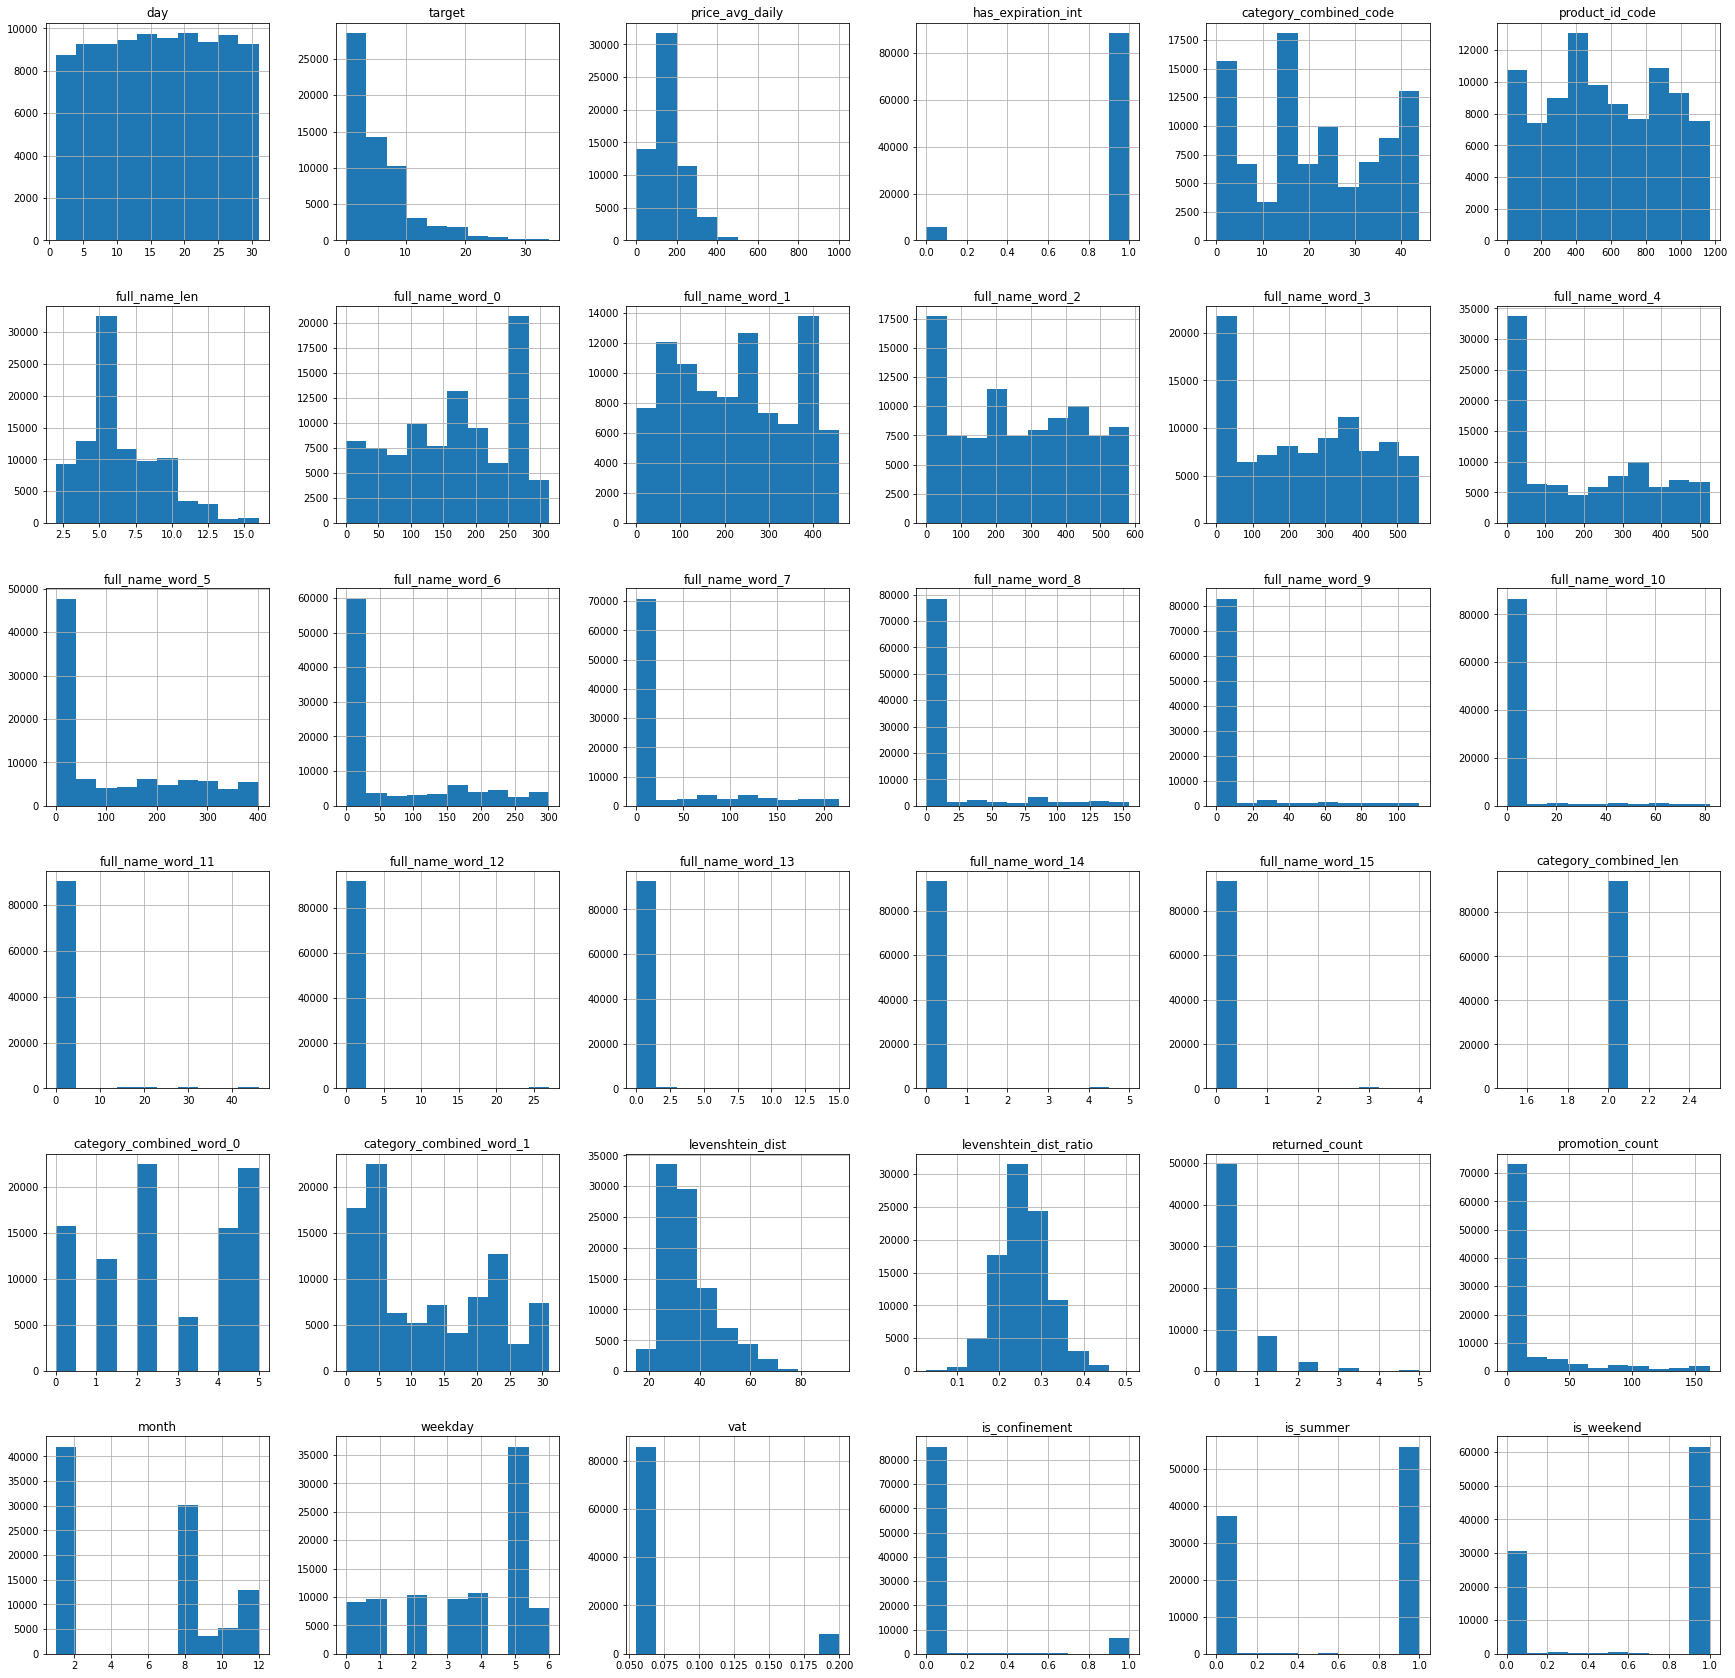

In [336]:
# visualise 
# visualise distribution
df_full.hist(figsize=(30,30))

In [373]:
df_full_filename = get_source_filename(output_path, 'df_full')
df_full.to_csv(df_full_filename, index= False)
pd.read_csv(df_full_filename)

,day,product_id,day_product_id,target,price_avg_daily,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,returned_count,promotion_count,month,weekday,vat,is_confinement,is_summer,is_weekend
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,8.0,268.03336,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.200,0.0,1.0,1.0
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,8.0,268.03336,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.200,0.0,1.0,1.0
2,3,5d0794866885630014681b97,3_5d0794866885630014681b97,8.0,268.03336,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.200,0.0,1.0,1.0
3,4,5d0794866885630014681b97,4_5d0794866885630014681b97,8.0,268.03336,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.200,0.0,1.0,1.0
4,5,5d0794866885630014681b97,5_5d0794866885630014681b97,8.0,268.03336,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.200,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94018,28,5fd2007b3cd6510017b506e2,28_5fd2007b3cd6510017b506e2,NaN,NaN,1.0,8.0,1080.0,5.0,161.0,105.0,542.0,493.0,480.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,5.0,30.0,0.352941,NaN,22.0,2,6,0.055,0.0,1.0,1.0
94019,28,5fdc81817de7f70017351dc3,28_5fdc81817de7f70017351dc3,NaN,NaN,1.0,16.0,1085.0,8.0,45.0,277.0,260.0,365.0,287.0,346.0,174.0,94.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,41.0,0.317073,NaN,0.0,2,6,0.055,0.0,1.0,1.0
94020,28,5fdf6bbe949d860017567dc8,28_5fdf6bbe949d860017567dc8,NaN,NaN,1.0,39.0,1107.0,6.0,16.0,17.0,167.0,297.0,335.0,21.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,5.0,20.0,30.0,0.268657,NaN,0.0,2,6,0.055,0.0,0.0,0.0
94021,28,5fdf6c9b3479d3001700d21a,28_5fdf6c9b3479d3001700d21a,NaN,NaN,1.0,39.0,1109.0,8.0,16.0,17.0,219.0,470.0,458.0,25.0,6.0,194.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,5.0,20.0,31.0,0.289855,NaN,0.0,2,6,0.055,0.0,1.0,1.0


# Machine learning model

In [361]:
# divide sets
df_test = df_full[df_full['month'] == 2]
df_valid = df_full[df_full['month'] == 1]
df_train = df_full[df_full['month'] > 2 ]
print(df_test.shape)
print(df_valid.shape)
print(df_train.shape)
columns_to_drop = ['product_id', 'day_product_id', 'target']

(32704, 38)
(9273, 38)
(52046, 38)


In [338]:
df_train.head()

,day,product_id,day_product_id,target,price_avg_daily,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,returned_count,promotion_count,month,weekday,vat,is_confinement,is_summer,is_weekend
0,1,5d0794866885630014681b97,1_5d0794866885630014681b97,8.0,268.033356,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.2,0.0,1.0,1.0
1,2,5d0794866885630014681b97,2_5d0794866885630014681b97,8.0,268.033356,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.2,0.0,1.0,1.0
2,3,5d0794866885630014681b97,3_5d0794866885630014681b97,8.0,268.033356,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.2,0.0,1.0,1.0
3,4,5d0794866885630014681b97,4_5d0794866885630014681b97,8.0,268.033356,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.2,0.0,1.0,1.0
4,5,5d0794866885630014681b97,5_5d0794866885630014681b97,8.0,268.033356,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,0.0,0.0,8,5,0.2,0.0,1.0,1.0


## Linear regression

In [375]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, random_state=0, max_iter=10000).fit(df_train.drop(columns=columns_to_drop), df_train['target'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


KeyboardInterrupt: ignored

In [ ]:
train_score = model.score(df_train.drop(columns=columns_to_drop), df_train['target'])
validation_score = model.score(df_valid.drop(columns=columns_to_drop), df_valid['target'])
print('Training score: ', train_score)
print('Validation score: ', validation_score)

## Random Forest Regressor

## XGBoost

In [339]:
# xgb
# from xgboost import XGBRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.005, 0.01, .03, 0.05,], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(
    df_train.drop(columns=columns_to_drop), 
    df_train['target'], 
    eval_metric="rmse", 
    eval_set=[(df_train.drop(columns=columns_to_drop), df_train['target']), (df_valid.drop(columns=columns_to_drop), df_valid['target'])], 
    verbose=True, 
    early_stopping_rounds = 20)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  36 out of  36 | elapsed: 17.9min finished


[0]	validation_0-rmse:6.80221	validation_1-rmse:8.83578
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.62862	validation_1-rmse:8.60923
[2]	validation_0-rmse:6.47393	validation_1-rmse:8.42829
[3]	validation_0-rmse:6.30993	validation_1-rmse:8.21685
[4]	validation_0-rmse:6.15226	validation_1-rmse:8.01023
[5]	validation_0-rmse:6.00466	validation_1-rmse:7.81095
[6]	validation_0-rmse:5.85862	validation_1-rmse:7.62025
[7]	validation_0-rmse:5.71824	validation_1-rmse:7.43757
[8]	validation_0-rmse:5.58133	validation_1-rmse:7.25537
[9]	validation_0-rmse:5.46427	validation_1-rmse:7.10153
[10]	validation_0-rmse:5.33712	validation_1-rmse:6.93222
[11]	validation_0-rmse:5.21718	validation_1-rmse:6.77342
[12]	validation_0-rmse:5.09799	validation_1-rmse:6.61664
[13]	validation_0-rmse:4.98141	validation_1-rmse:6.46679
[14]	validation_0-rmse:4.87978	validation_1-rmse:6.33

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.005, 0.01, 0.03, 0.05],
                         'max_depth': [5, 6, 7], 'min_child_weight': [4],
                         '

In [340]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.4604293467493587
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


In [341]:
model = XGBRegressor(
    colsample_bytree=0.7, 
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=4, 
    n_estimators=500,
    subsample=0.7, )

In [342]:

model.fit(
    df_train.drop(columns=columns_to_drop), 
    df_train['target'], 
    eval_metric="rmse", 
    eval_set=[(df_train.drop(columns=columns_to_drop), df_train['target']), (df_valid.drop(columns=columns_to_drop), df_valid['target'])], 
    verbose=True, 
    early_stopping_rounds = 20)

[10:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.80268	validation_1-rmse:8.83574
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.62911	validation_1-rmse:8.60915
[2]	validation_0-rmse:6.47393	validation_1-rmse:8.42825
[3]	validation_0-rmse:6.30977	validation_1-rmse:8.21684
[4]	validation_0-rmse:6.15245	validation_1-rmse:8.01021
[5]	validation_0-rmse:6.00434	validation_1-rmse:7.81094
[6]	validation_0-rmse:5.85868	validation_1-rmse:7.62026
[7]	validation_0-rmse:5.71819	validation_1-rmse:7.4376
[8]	validation_0-rmse:5.58121	validation_1-rmse:7.25536
[9]	validation_0-rmse:5.46408	validation_1-rmse:7.10153
[10]	validation_0-rmse:5.33707	validation_1-rmse:6.93221
[11]	validation_0-rmse:5.217	validation_1-rmse:6.77345
[12]	validation_0-rmse:5.09795	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=1)

In [347]:
model.score(df_train.drop(columns=columns_to_drop), df_train['target'])

0.9139818582209824

In [343]:
model.score(df_valid.drop(columns=columns_to_drop), df_valid['target'])

0.8447351920855463

In [362]:
df_test['target'] = model.predict(df_test.drop(columns=columns_to_drop))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [363]:
df_test.head()

,day,product_id,day_product_id,target,price_avg_daily,has_expiration_int,category_combined_code,product_id_code,full_name_len,full_name_word_0,full_name_word_1,full_name_word_2,full_name_word_3,full_name_word_4,full_name_word_5,full_name_word_6,full_name_word_7,full_name_word_8,full_name_word_9,full_name_word_10,full_name_word_11,full_name_word_12,full_name_word_13,full_name_word_14,full_name_word_15,category_combined_len,category_combined_word_0,category_combined_word_1,levenshtein_dist,levenshtein_dist_ratio,returned_count,promotion_count,month,weekday,vat,is_confinement,is_summer,is_weekend
61319,1,5d0794866885630014681b97,1_5d0794866885630014681b97,2.636480,NaN,0.0,23.0,29.0,8.0,158.0,75.0,582.0,381.0,419.0,10.0,75.0,61.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,41.0,0.233766,NaN,0.0,2,0,0.200,0.0,1.0,1.0
61320,1,5cebfa8d0b259700045dc8b2,1_5cebfa8d0b259700045dc8b2,1.743157,NaN,1.0,16.0,9.0,4.0,109.0,63.0,469.0,350.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,27.0,0.333333,NaN,0.0,2,0,0.055,0.0,1.0,1.0
61321,1,5d0794866885630014681b9c,1_5d0794866885630014681b9c,2.629592,NaN,0.0,23.0,33.0,9.0,79.0,215.0,3.0,244.0,21.0,401.0,18.0,101.0,127.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,13.0,48.0,0.209302,NaN,0.0,2,0,0.200,0.0,1.0,1.0
61322,1,602a2d81304b800015a177ca,1_602a2d81304b800015a177ca,4.287703,NaN,1.0,19.0,1143.0,5.0,145.0,310.0,181.0,258.0,516.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,6.0,32.0,0.253968,NaN,0.0,2,0,0.055,0.0,1.0,1.0
61323,1,602a2c983ddc3100158d6b06,1_602a2c983ddc3100158d6b06,1.487258,NaN,1.0,15.0,1142.0,5.0,165.0,410.0,477.0,397.0,511.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,26.0,30.0,0.276923,NaN,0.0,2,0,0.055,0.0,1.0,1.0


In [365]:
import datetime
submission_df = df_test[['day', 'product_id', 'target']]
submission_df['target'] = submission_df['target'].astype(int)
submission_df['day'] = submission_df.day.apply(lambda x: datetime.date(2021,2,x))
submission_df.columns = ['Date', 'product_id', 'sales_quantity']
submission_filename = get_source_filename(output_path, 'submission')
submission_df.to_csv(subimission_filename, index=False)
print(submission_filename)
submission_df.head()


/content/drive/My Drive/Colab Notebooks/storelift/outputs/submission.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Date,product_id,sales_quantity
61319,2021-02-01,5d0794866885630014681b97,2
61320,2021-02-01,5cebfa8d0b259700045dc8b2,1
61321,2021-02-01,5d0794866885630014681b9c,2
61322,2021-02-01,602a2d81304b800015a177ca,4
61323,2021-02-01,602a2c983ddc3100158d6b06,1


In [371]:
import datetime
def save_submission(df_test, model, filename='submission'):    
  submission_df = df_test[['day', 'product_id', 'target']]
  submission_df['target'] = submission_df['target'].astype(int)
  
  submission_df['day'] = submission_df.day.apply(lambda x: datetime.date(2021,2,x))
  submission_df.columns = ['Date', 'product_id', 'sales_quantity']

  submission_filename = get_source_filename(output_path, filename)
  submission_df.to_csv(subimission_filename, index=False)
  
  print(submission_filename)
  submission_df.head()

save_submission(df_test, model)
pd.read_csv(subimission_filename)

/content/drive/My Drive/Colab Notebooks/storelift/outputs/submission.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,product_id,sales_quantity
0,2021-02-01,5d0794866885630014681b97,2
1,2021-02-01,5cebfa8d0b259700045dc8b2,1
2,2021-02-01,5d0794866885630014681b9c,2
3,2021-02-01,602a2d81304b800015a177ca,4
4,2021-02-01,602a2c983ddc3100158d6b06,1
...,...,...,...
32699,2021-02-28,5fd2007b3cd6510017b506e2,1
32700,2021-02-28,5fdc81817de7f70017351dc3,2
32701,2021-02-28,5fdf6bbe949d860017567dc8,0
32702,2021-02-28,5fdf6c9b3479d3001700d21a,0
